In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import shap

# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2

# Import evaluation metric libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Import Sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler

# Import Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
# Load preprocessed data
X_train = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\X_train_processed.csv')
X_test = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\X_test_processed.csv')
y_train = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\y_train.csv').squeeze()
y_test = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\y_test.csv').squeeze()

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle weights and classes 
#classes = y_train.unique()
#weights_dict = dict(pd.Series(y_train).value_counts(normalize=True))

In [56]:
features = X_train.columns


Samples in the original dataset:  247019
Samples in the resampled dataset:  307022


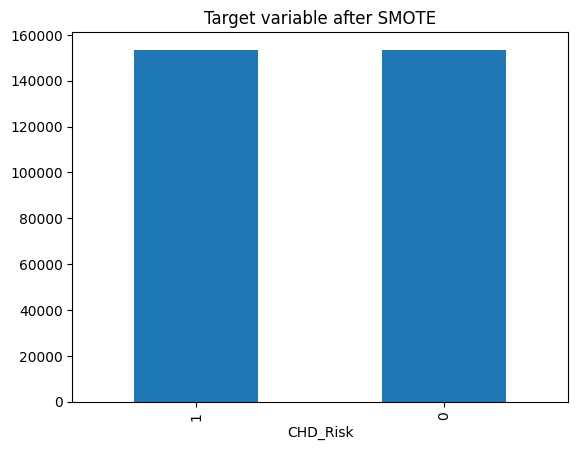

In [57]:
from imblearn.combine import SMOTETomek

X_smote, y_smote = SMOTETomek(random_state=0).fit_resample(X_train_scaled, y_train)

print('Samples in the original dataset: ', len(y_train))
print('Samples in the resampled dataset: ', len(y_smote))

y_smote.value_counts().plot(kind='bar', title='Target variable after SMOTE')
plt.show()

In [58]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='d', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='d', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    #sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    #sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")

    try:
      try:
        feature_importance = model.feature_importances_
      except:
        feature_importance = model.coef_
      feature_importance = np.absolute(feature_importance)
      if len(feature_importance)==len(features):
        pass
      else:
        feature_importance = feature_importance[0]


      feat = pd.Series(feature_importance, index=features)
      feat = feat.sort_values(ascending=True)
      plt.figure(figsize=(10,6))
      plt.title('Feature Importances for '+str(model), fontsize = 18)
      plt.xlabel('Relative Importance')
      feat.plot(kind='barh', colormap= 'Dark2')
    except AttributeError:
        print("\nThe model does not have feature importances attribute.")

    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score
    

score = pd.DataFrame(index = ['Precision Train', 'Precision Test','Recall Train','Recall Test','Accuracy Train', 'Accuracy Test','ROC-AUC Train', 'ROC-AUC Test','F1 macro Train', 'F1 macro Test'])

# Logistic Regression 


Train ROC AUC: 0.6467582127665119
Test ROC AUC: 0.6354661610323085


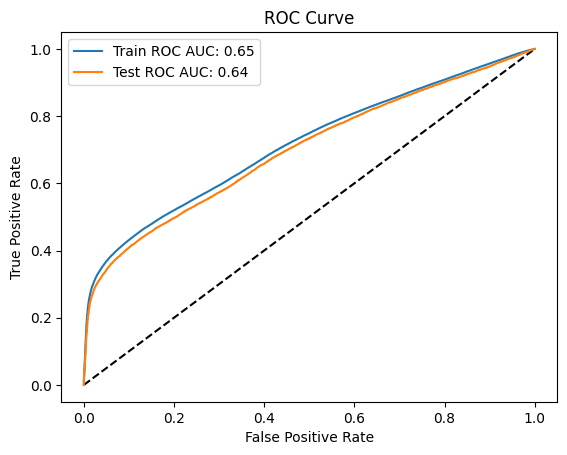


Confusion Matrix:


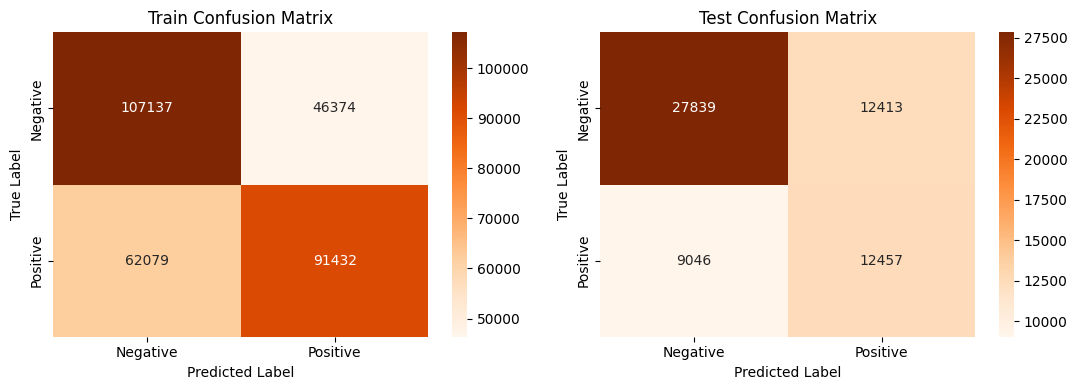


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.633138 | 0.697911 |   0.663948 | 153511        |
| 1            |    0.663483 | 0.595606 |   0.627715 | 153511        |
| accuracy     |    0.646758 | 0.646758 |   0.646758 |      0.646758 |
| macro avg    |    0.64831  | 0.646758 |   0.645831 | 307022        |
| weighted avg |    0.64831  | 0.646758 |   0.645831 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.754751 | 0.691618 |   0.721807 | 40252        |
| 1            |    0.500885 | 0.579315 |   0.537252 | 21503        |
| accuracy     |    0.652514 | 0.652514 |   0.652514 |     0.652514 |
| macro avg    |    0.627818 | 0.635466 |   0.629529 | 61755        |
| weighted avg |    0.66

Log Reg
Precision Train  0.648310
Precision Test   0.666355
Recall Train     0.646758
Recall Test      0.652514
Accuracy Train   0.646758
Accuracy Test    0.652514
ROC-AUC Train    0.646758
ROC-AUC Test     0.635466
F1 macro Train   0.645831
F1 macro Test    0.657545

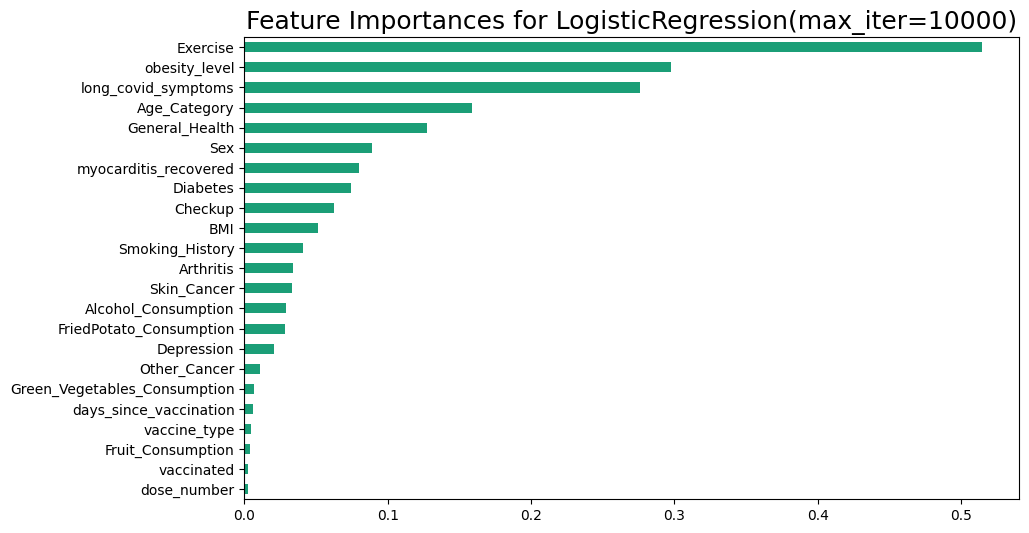

In [59]:
lr_model = LogisticRegression(fit_intercept=True, max_iter=10000)
# Visualizing evaluation Metric Score chart
lr_score = evaluate_model(lr_model, X_smote, X_test_scaled, y_smote, y_test) #use scaled data only here

score['Log Reg'] = lr_score
score

### Cross- Validation & Hyperparameter Tuning

In [60]:
# Define hyperparameter grid carefully considering solver-penalty compatibility
param_grid = [
    {'C': [100,10,1,0.1,0.01,0.001],
     'penalty': ['l1'],
     'solver': ['liblinear', 'saga']},
    {'C': [100,10,1,0.1,0.01,0.001],
     'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
]

# Initialize Logistic Regression without specifying solver or penalty upfront
logreg = LogisticRegression(fit_intercept=True, max_iter=1000, random_state=0, class_weight='balanced')

# Repeated Stratified K-Fold CV
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=0)

# Setup GridSearchCV with logistic regression and your param_grid
grid = GridSearchCV(logreg, param_grid, cv=rskf, n_jobs=-1, scoring='roc_auc')  # or your preferred scoring metric

# Fit on scaled training data
grid.fit(X_smote, y_smote)

# Best hyperparameters
best_params = grid.best_params_
print("Best hyperparameters:", best_params)

# Train model with best params
lr_model2 = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=0,
    class_weight='balanced'
)

# Fit on full training data
lr_model2.fit(X_smote, y_smote)


Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=0)


Train ROC AUC: 0.6467614698620946
Test ROC AUC: 0.6354661610323085


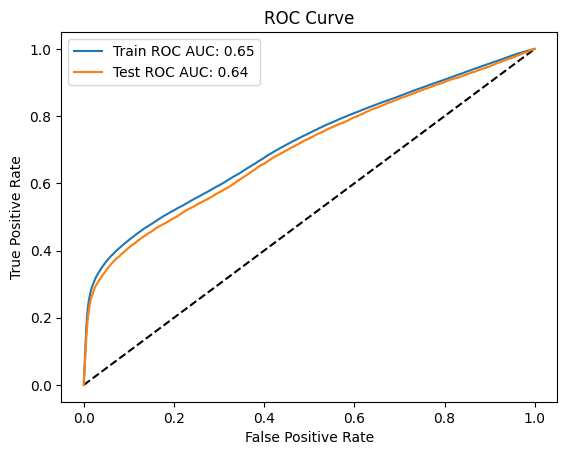


Confusion Matrix:


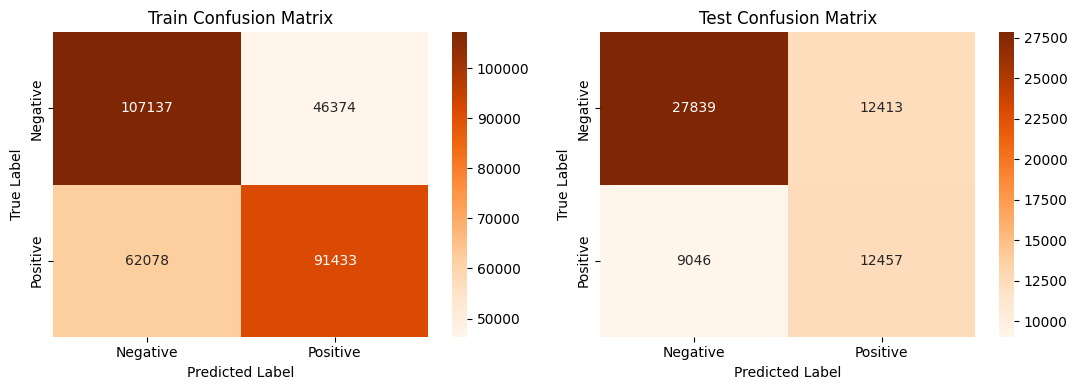


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.633141 | 0.697911 |   0.66395  | 153511        |
| 1            |    0.663486 | 0.595612 |   0.62772  | 153511        |
| accuracy     |    0.646761 | 0.646761 |   0.646761 |      0.646761 |
| macro avg    |    0.648314 | 0.646761 |   0.645835 | 307022        |
| weighted avg |    0.648314 | 0.646761 |   0.645835 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.754751 | 0.691618 |   0.721807 | 40252        |
| 1            |    0.500885 | 0.579315 |   0.537252 | 21503        |
| accuracy     |    0.652514 | 0.652514 |   0.652514 |     0.652514 |
| macro avg    |    0.627818 | 0.635466 |   0.629529 | 61755        |
| weighted avg |    0.66

Log Reg  Tuned LR
Precision Train  0.648310  0.648314
Precision Test   0.666355  0.666355
Recall Train     0.646758  0.646761
Recall Test      0.652514  0.652514
Accuracy Train   0.646758  0.646761
Accuracy Test    0.652514  0.652514
ROC-AUC Train    0.646758  0.646761
ROC-AUC Test     0.635466  0.635466
F1 macro Train   0.645831  0.645835
F1 macro Test    0.657545  0.657545

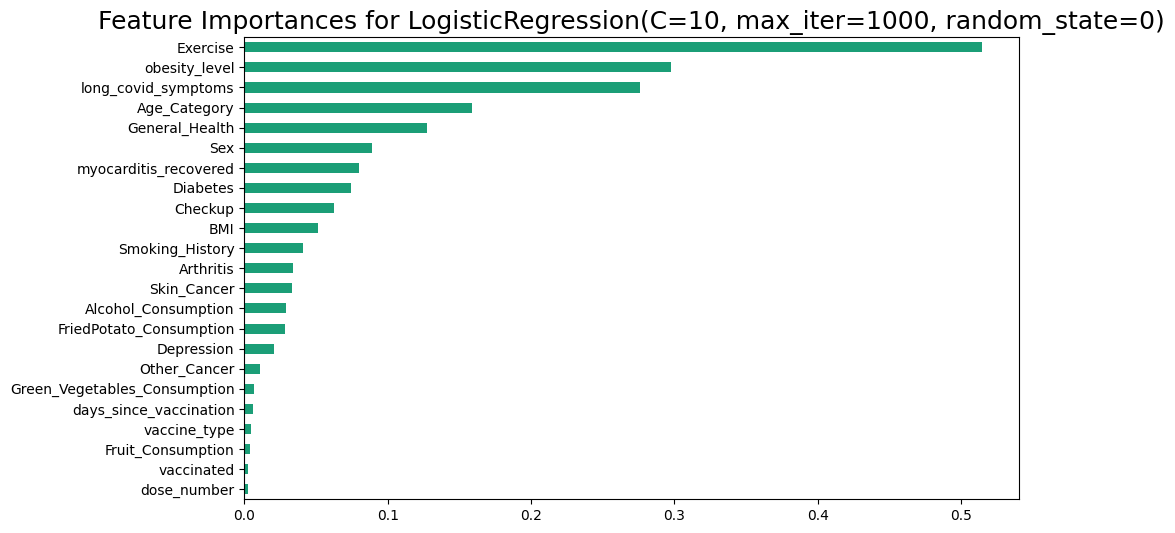

In [61]:
# Initiate model with best parameters
lr_model2 = LogisticRegression(C=best_params['C'],
                                  penalty=best_params['penalty'],
                                  solver=best_params['solver'],
                                  max_iter=1000, random_state=0)

# Visualizing evaluation Metric Score chart
lr_score2 = evaluate_model(lr_model2, X_smote, X_test_scaled, y_smote, y_test)

score['Tuned LR'] = lr_score2
# Updated Evaluation metric Score Chart
score

# K Nearest Neighbour 


Train ROC AUC: 0.8396596986535166
Test ROC AUC: 0.616055695719765


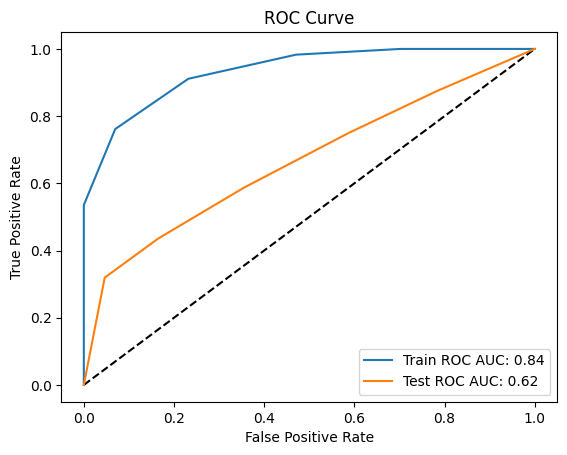


Confusion Matrix:


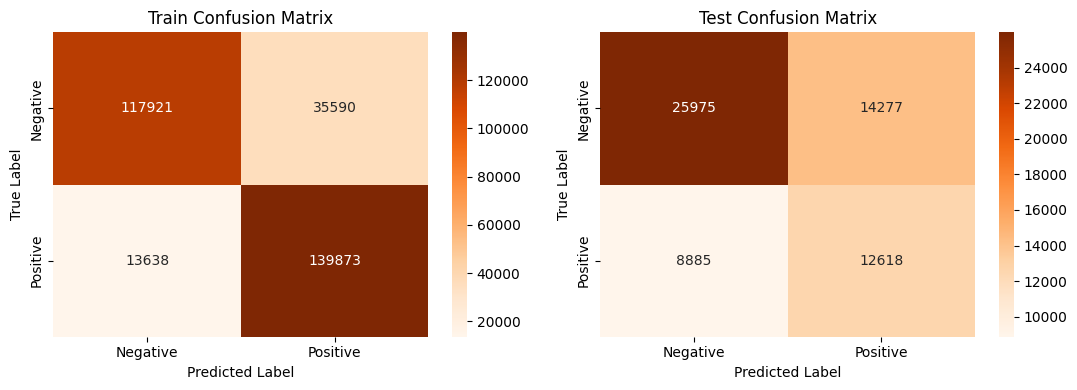


Train Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.896335 | 0.76816  |   0.827313 | 153511       |
| 1            |    0.797165 | 0.911159 |   0.850359 | 153511       |
| accuracy     |    0.83966  | 0.83966  |   0.83966  |      0.83966 |
| macro avg    |    0.84675  | 0.83966  |   0.838836 | 307022       |
| weighted avg |    0.84675  | 0.83966  |   0.838836 | 307022       |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.745123 | 0.64531  |   0.691634 | 40252        |
| 1            |    0.469158 | 0.586802 |   0.521427 | 21503        |
| accuracy     |    0.624937 | 0.624937 |   0.624937 |     0.624937 |
| macro avg    |    0.607141 | 0.616056 |   0.60653  | 61755        |
| weighted avg |    0.649033 | 

Log Reg  Tuned LR       KNN
Precision Train  0.648310  0.648314  0.846750
Precision Test   0.666355  0.666355  0.649033
Recall Train     0.646758  0.646761  0.839660
Recall Test      0.652514  0.652514  0.624937
Accuracy Train   0.646758  0.646761  0.839660
Accuracy Test    0.652514  0.652514  0.624937
ROC-AUC Train    0.646758  0.646761  0.839660
ROC-AUC Test     0.635466  0.635466  0.616056
F1 macro Train   0.645831  0.645835  0.838836
F1 macro Test    0.657545  0.657545  0.632368

In [62]:
knn_model =  KNeighborsClassifier(n_neighbors=5)

knn_score = evaluate_model(knn_model, X_smote, X_test_scaled, y_smote, y_test)

score['KNN'] = knn_score
score

# SVM


Train ROC AUC: 0.6637279548362329
Test ROC AUC: 0.6526876975033867


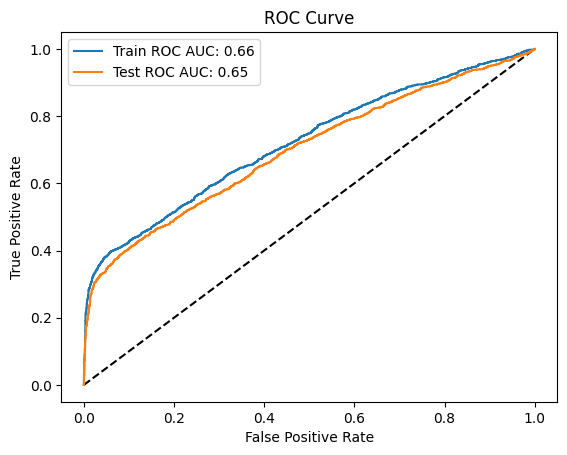


Confusion Matrix:


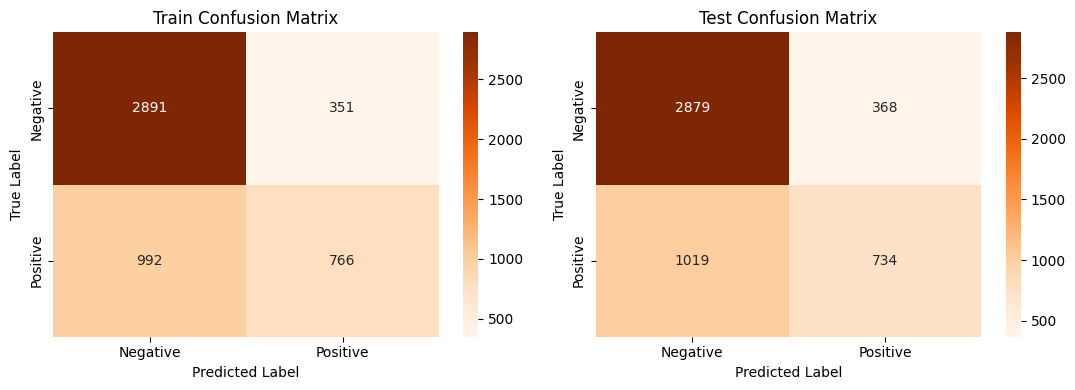


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.744527 | 0.891733 |   0.811509 | 3242      |
| 1            |    0.685765 | 0.435722 |   0.53287  | 1758      |
| accuracy     |    0.7314   | 0.7314   |   0.7314   |    0.7314 |
| macro avg    |    0.715146 | 0.663728 |   0.672189 | 5000      |
| weighted avg |    0.723867 | 0.7314   |   0.713539 | 5000      |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.738584 | 0.886665 |   0.805878 | 3247      |
| 1            |    0.666062 | 0.418711 |   0.514186 | 1753      |
| accuracy     |    0.7226   | 0.7226   |   0.7226   |    0.7226 |
| macro avg    |    0.702323 | 0.652688 |   0.660032 | 5000      |
| weighted avg |    0.713158 | 0.7226   |   0.703611 | 5000      |

Th

Log Reg  Tuned LR       KNN  LinearSVM
Precision Train  0.648310  0.648314  0.846750   0.723867
Precision Test   0.666355  0.666355  0.649033   0.713158
Recall Train     0.646758  0.646761  0.839660   0.731400
Recall Test      0.652514  0.652514  0.624937   0.722600
Accuracy Train   0.646758  0.646761  0.839660   0.731400
Accuracy Test    0.652514  0.652514  0.624937   0.722600
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688
F1 macro Train   0.645831  0.645835  0.838836   0.713539
F1 macro Test    0.657545  0.657545  0.632368   0.703611

In [63]:

svm_raw = LinearSVC(random_state=0, max_iter=5000)
svm_model = CalibratedClassifierCV(svm_raw)  # Adds predict_proba

# Fit on small subset if full data is too big
X_small = X_train_scaled[:5000]
y_small = y_train[:5000]
svm_model.fit(X_small, y_small)

# Evaluate
svm_score = evaluate_model(svm_model, X_small, X_test_scaled[:5000], y_small, y_test[:5000])
score['LinearSVM'] = svm_score
score

### Cross- Validation & Hyperparameter Tuning

In [64]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real

# Define parameter space
param_space = {'estimator__C': Real(0.01, 10.0, prior='log-uniform')}

# LinearSVC with calibration
base_svm = LinearSVC(random_state=0, max_iter=5000)
svm = CalibratedClassifierCV(estimator=base_svm, method='sigmoid', cv=3)

# Bayesian optimization
random_search = BayesSearchCV(
    estimator=svm,
    search_spaces=param_space,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=0
)

# Use smaller data sample to keep training fast
X_small = X_smote[:3000]
y_small = y_smote[:3000]

random_search.fit(X_small, y_small)
best_params = random_search.best_params_

print("✅ Best hyperparameters:", random_search.best_params_)


✅ Best hyperparameters: OrderedDict([('estimator__C', 0.3916449174261764)])



Train ROC AUC: 0.6460742226941392
Test ROC AUC: 0.6346294370901631


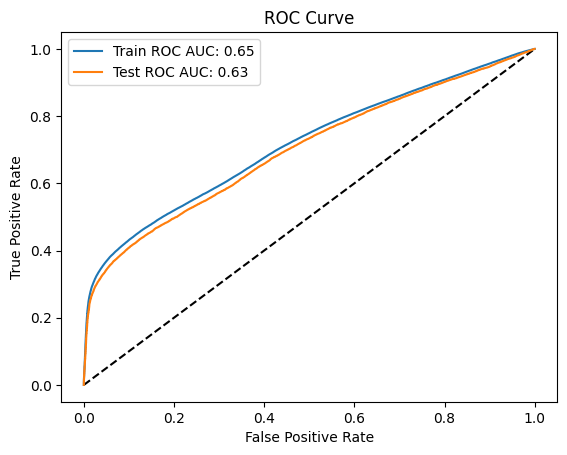


Confusion Matrix:


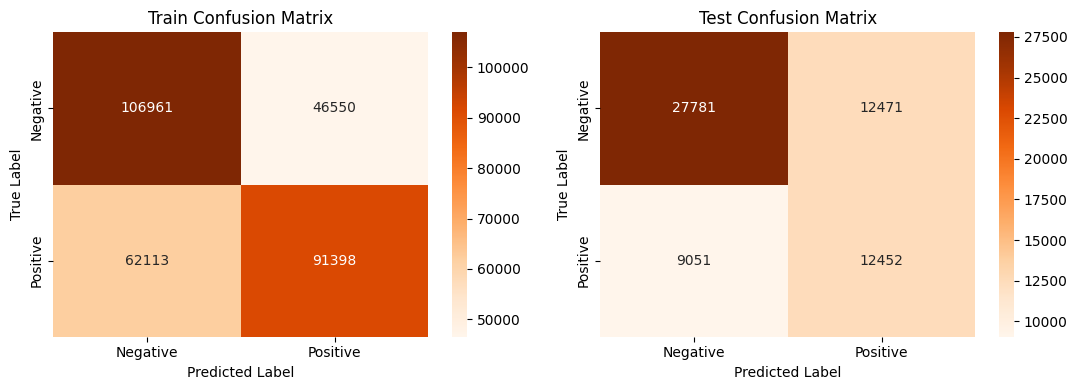


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.632628 | 0.696764 |   0.663149 | 153511        |
| 1            |    0.662554 | 0.595384 |   0.627176 | 153511        |
| accuracy     |    0.646074 | 0.646074 |   0.646074 |      0.646074 |
| macro avg    |    0.647591 | 0.646074 |   0.645162 | 307022        |
| weighted avg |    0.647591 | 0.646074 |   0.645162 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.754263 | 0.690177 |   0.720798 | 40252        |
| 1            |    0.499619 | 0.579082 |   0.536424 | 21503        |
| accuracy     |    0.651494 | 0.651494 |   0.651494 |     0.651494 |
| macro avg    |    0.626941 | 0.634629 |   0.628611 | 61755        |
| weighted avg |    0.66

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599

In [65]:
base_svm = LinearSVC(C=best_params['estimator__C'], random_state=0, max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm, method='sigmoid', cv=3)

# Fit on your full training data
svm_model2.fit(X_smote, y_smote)

# Evaluate
svm2_score = evaluate_model(svm_model2, X_smote, X_test_scaled, y_smote, y_test)
score['SVM tuned'] = svm2_score
# Updated Evaluation metric Score Chart
score

<!--  -->

# Decision Tree


Train ROC AUC: 1.0
Test ROC AUC: 0.6161354194750812


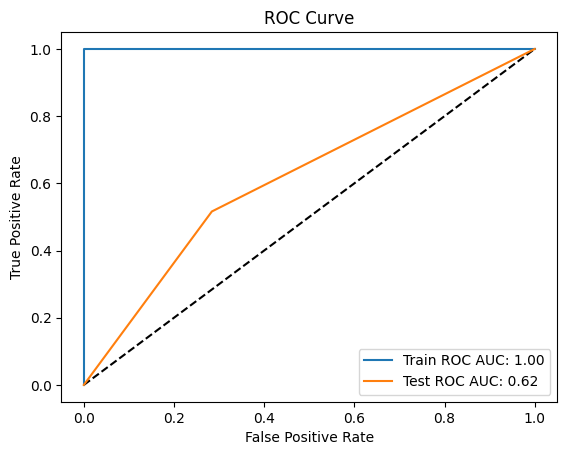


Confusion Matrix:


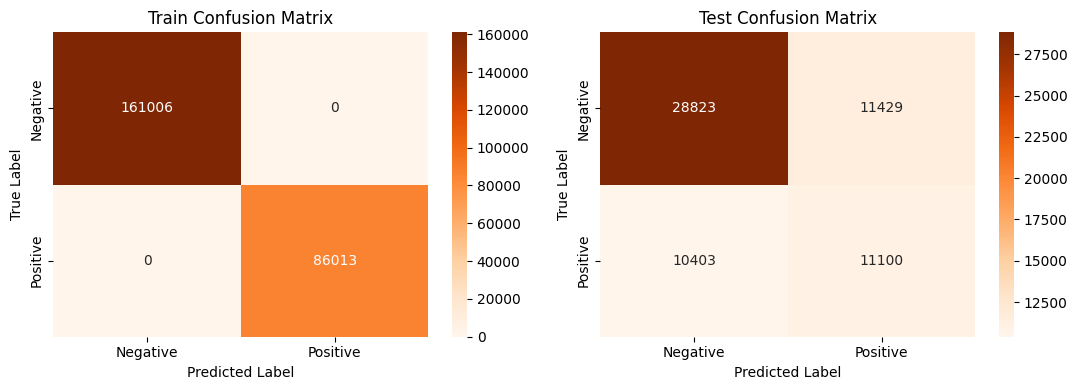


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |    161006 |
| 1            |           1 |        1 |          1 |     86013 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |    247019 |
| weighted avg |           1 |        1 |          1 |    247019 |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.734793 | 0.716064 |   0.725308 | 40252        |
| 1            |    0.492698 | 0.516207 |   0.504179 | 21503        |
| accuracy     |    0.646474 | 0.646474 |   0.646474 |     0.646474 |
| macro avg    |    0.613746 | 0.616135 |   0.614743 | 61755        |
| weighted avg |    0.650496 | 0.646474 |   0.648311

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311

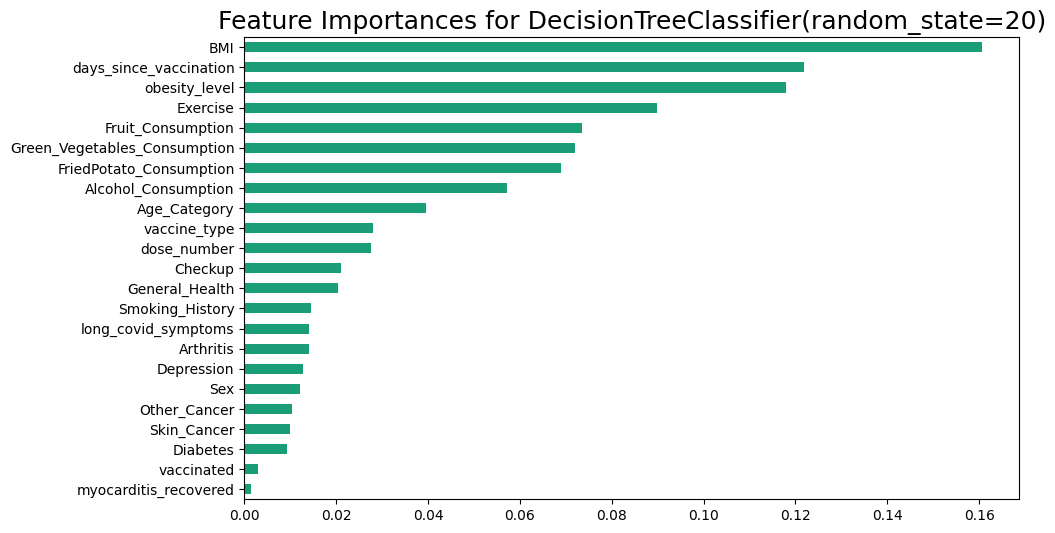

In [66]:
dt_model = DecisionTreeClassifier(random_state=20)

# Visualizing evaluation Metric Score chart
dt_score = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Updated Evaluation metric Score Chart
score['DT'] = dt_score
score

### Cross- Validation & Hyperparameter Tuning

Decision Tree CV Accuracy:  0.7013929057211323

Train ROC AUC: 0.7052230784764609
Test ROC AUC: 0.6694439676829446


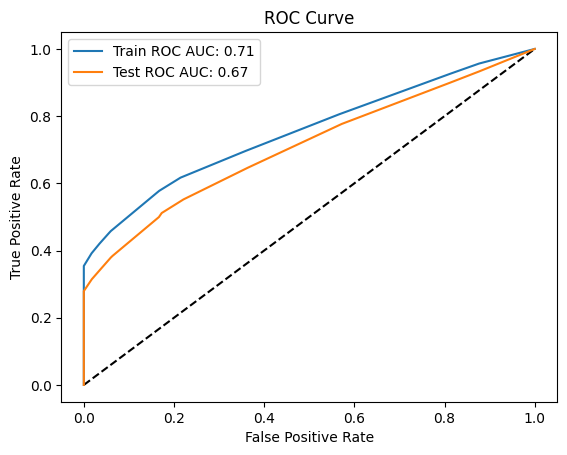


Confusion Matrix:


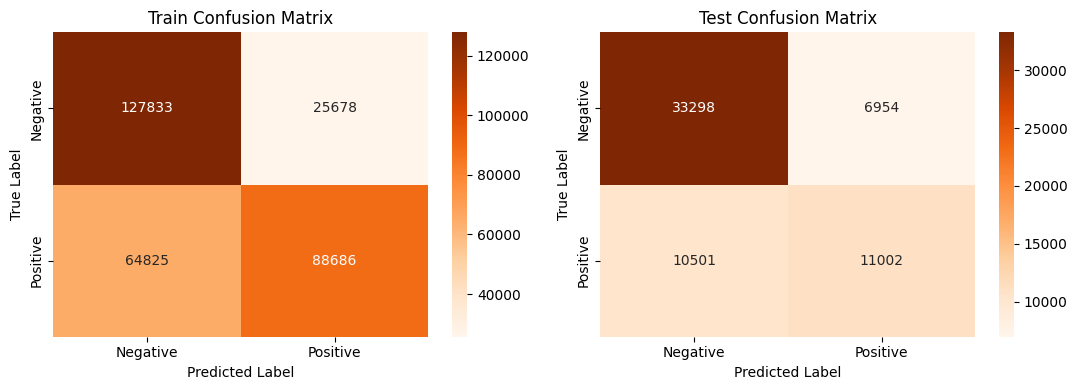


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.663523 | 0.832729 |   0.738558 | 153511        |
| 1            |    0.775471 | 0.577718 |   0.662145 | 153511        |
| accuracy     |    0.705223 | 0.705223 |   0.705223 |      0.705223 |
| macro avg    |    0.719497 | 0.705223 |   0.700351 | 307022        |
| weighted avg |    0.719497 | 0.705223 |   0.700351 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.760246 | 0.827238 |   0.792328 | 40252        |
| 1            |    0.61272  | 0.51165  |   0.557642 | 21503        |
| accuracy     |    0.717351 | 0.717351 |   0.717351 |     0.717351 |
| macro avg    |    0.686483 | 0.669444 |   0.674985 | 61755        |
| weighted avg |    0.70

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  
Precision Train  0.719497  
Precision Test   0.708877  
Recall Train     0.705223  
Recall Test      0.717351  
Accuracy Train   0.705223  
Accuracy Test    0.717351  
ROC-AUC Train    0.705223  
ROC-AUC Test     0.669444  
F1 macro Train   0.700351  
F1 macro Test    0.710611

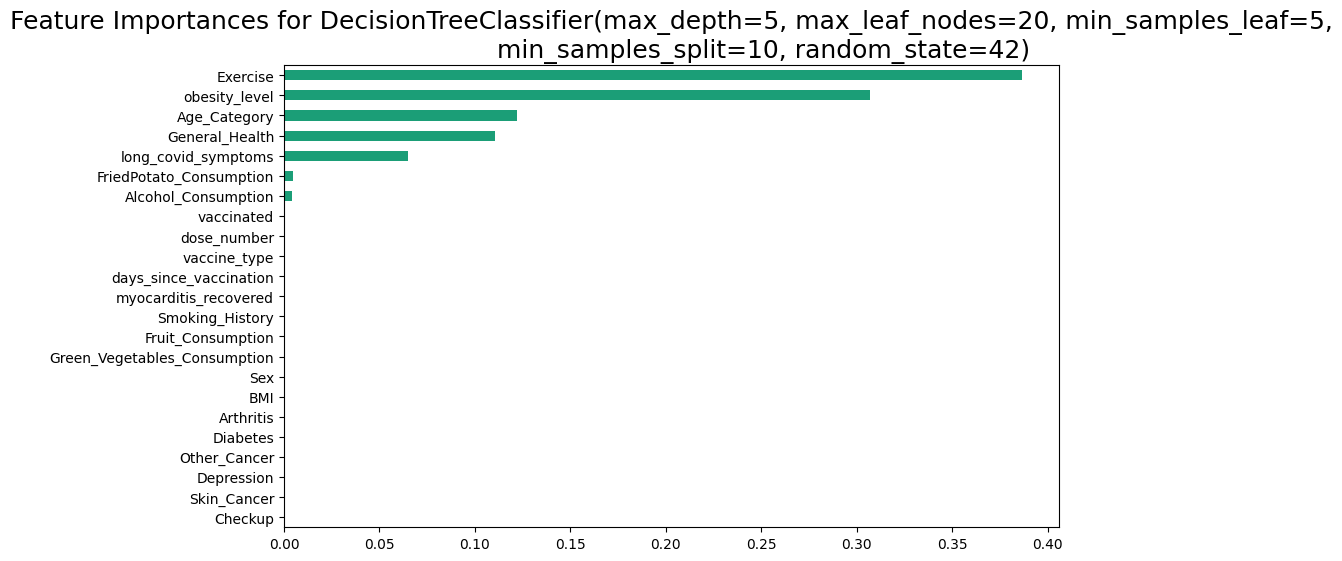

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Pruned / regularized Decision Tree
dt = DecisionTreeClassifier(
    max_depth=5,             # Limit tree depth
    min_samples_split=10,    # Minimum samples to split an internal node
    min_samples_leaf=5,      # Minimum samples at leaf
    max_leaf_nodes=20,       # Max number of leaf nodes
    random_state=42
)

# Cross-validate
cv_scores = cross_val_score(dt, X_smote, y_smote, cv=5, scoring='accuracy')
print("Decision Tree CV Accuracy: ", cv_scores.mean())

dt.fit(X_smote, y_smote)
rf_score = evaluate_model(dt, X_smote, X_test_scaled, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['Reg DT'] = rf_score
score

Fitting 9 folds for each of 20 candidates, totalling 180 fits
Best hyperparameters (RandomSearchCV): {'min_samples_split': np.int64(3), 'min_samples_leaf': np.int64(19), 'max_depth': 8}

Train ROC AUC: 0.7425526509500947
Test ROC AUC: 0.6686749495478397


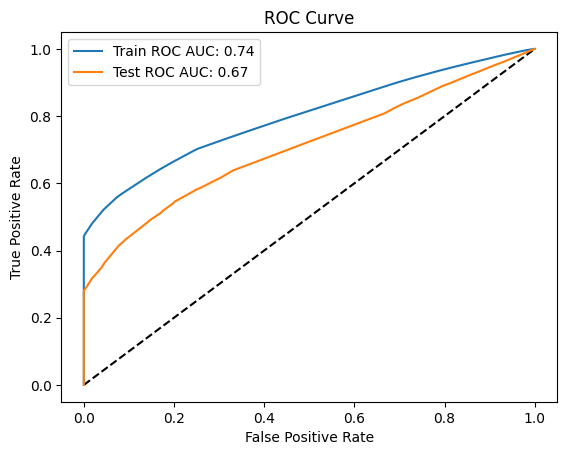


Confusion Matrix:


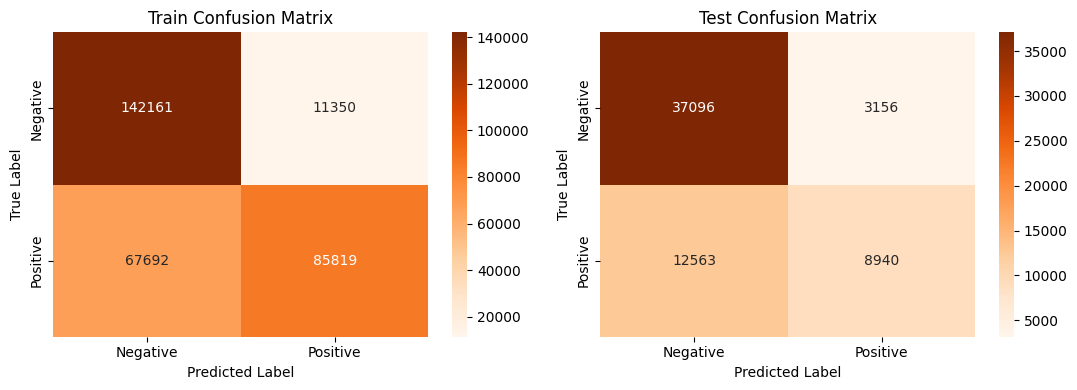


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.677431 | 0.926064 |   0.782472 | 153511        |
| 1            |    0.883193 | 0.559041 |   0.68469  | 153511        |
| accuracy     |    0.742553 | 0.742553 |   0.742553 |      0.742553 |
| macro avg    |    0.780312 | 0.742553 |   0.733581 | 307022        |
| weighted avg |    0.780312 | 0.742553 |   0.733581 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.747015 | 0.921594 |   0.825172 | 40252        |
| 1            |    0.739087 | 0.415756 |   0.532159 | 21503        |
| accuracy     |    0.745462 | 0.745462 |   0.745462 |     0.745462 |
| macro avg    |    0.743051 | 0.668675 |   0.678665 | 61755        |
| weighted avg |    0.74

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned  
Precision Train  0.719497  0.780312  
Precision Test   0.708877  0.744254  
Recall Train     0.705223  0.742553  
Recall Test      0.717351  0.745462  
Accuracy Train   0.705223  0.742553  
Accuracy Test    0.717351  0.745462  
ROC-AUC Train    0.705223  0.742553  
ROC-AUC Test     0.669444  0.668675  
F1 macro Train   0.700351  0.733581  
F1 macro Test    0.710611  0.723145

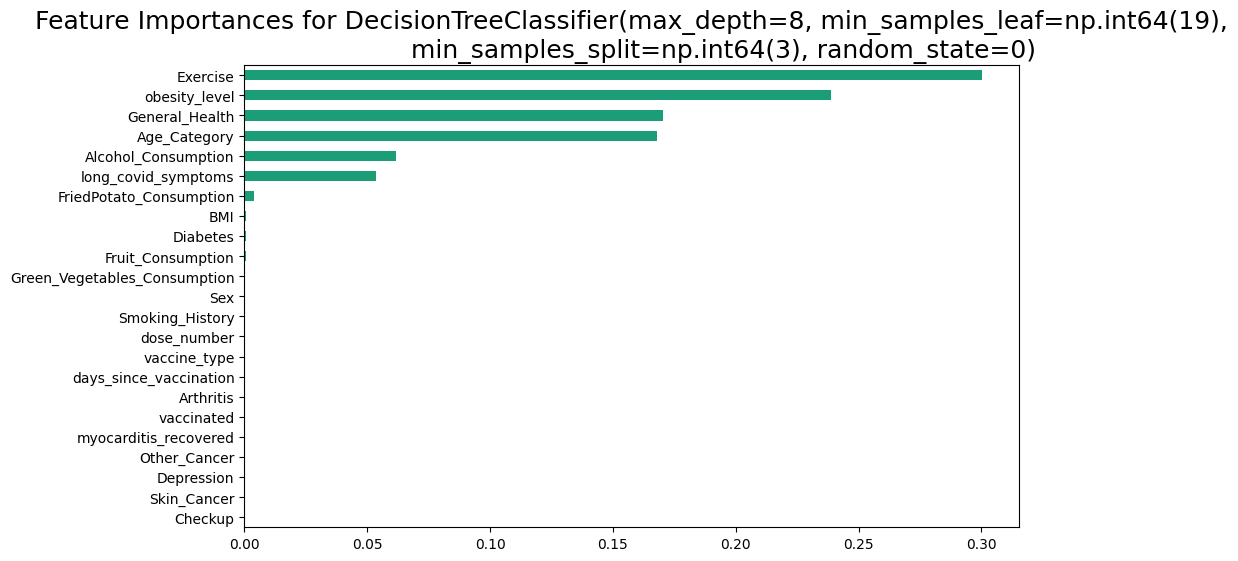

In [68]:
# Define the hyperparameter distribution
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': np.arange(2, 8),
    'min_samples_leaf': np.arange(10, 20)
}

# Initialize the model
model = DecisionTreeClassifier(random_state=0)

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Randomized Search with fewer iterations
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,                 # Try 20 random combinations
    cv=rskf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=0,
    verbose=1
)

# Fit the search
random_search.fit(X_smote, y_smote)

# Best parameters
best_params_tree = random_search.best_params_
print("Best hyperparameters (RandomSearchCV):", best_params_tree)

# Train final model
tree_model = DecisionTreeClassifier(**best_params_tree, random_state=0)
tree_model.fit(X_train_scaled, y_train)

# Evaluate
tree_score = evaluate_model(tree_model, X_smote, X_test_scaled, y_smote, y_test)
# Store score
score['DT Tuned'] = tree_score

# ✅ Fixed print statement
print("Best hyperparameters: ", best_params_tree)
score

# Random Forest


Train ROC AUC: 0.9999967429044172
Test ROC AUC: 0.6605505444287697


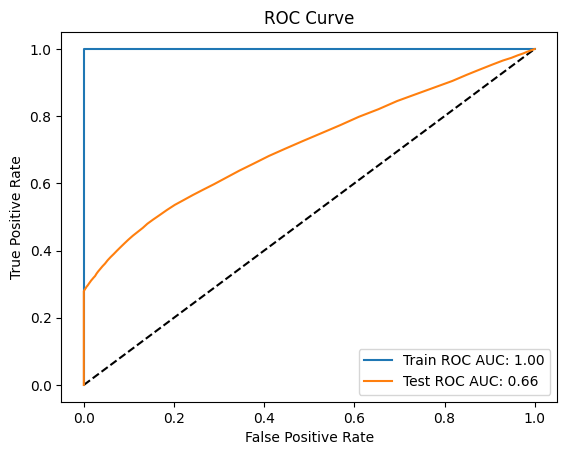


Confusion Matrix:


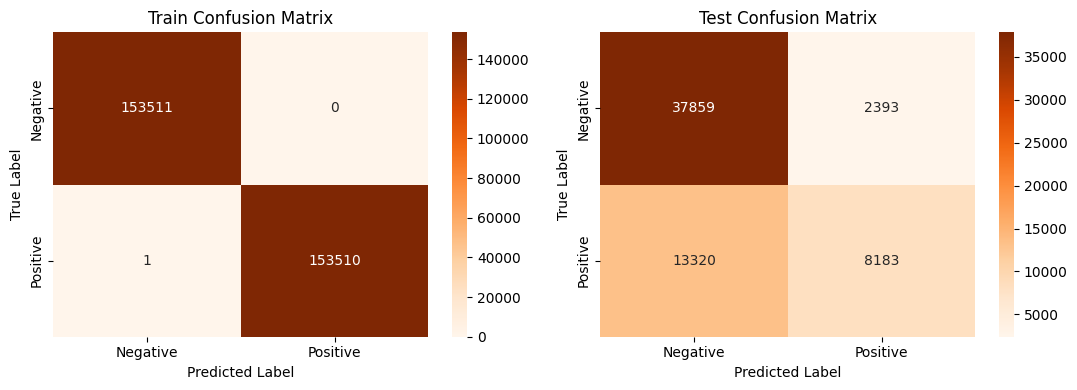


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.999993 | 1        |   0.999997 | 153511        |
| 1            |    1        | 0.999993 |   0.999997 | 153511        |
| accuracy     |    0.999997 | 0.999997 |   0.999997 |      0.999997 |
| macro avg    |    0.999997 | 0.999997 |   0.999997 | 307022        |
| weighted avg |    0.999997 | 0.999997 |   0.999997 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.739737 | 0.94055  |   0.828144 | 40252        |
| 1            |    0.773733 | 0.380552 |   0.510178 | 21503        |
| accuracy     |    0.745559 | 0.745559 |   0.745559 |     0.745559 |
| macro avg    |    0.756735 | 0.660551 |   0.669161 | 61755        |
| weighted avg |    0.75

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest  
Precision Train  0.719497  0.780312  0.999997  
Precision Test   0.708877  0.744254  0.751574  
Recall Train     0.705223  0.742553  0.999997  
Recall Test      0.717351  0.745462  0.745559  
Accuracy Train   0.705223  0.742553  0.999997  
Accuracy Test    0.717351  0.745462  0.745559  
ROC-AUC Train    0.705223  0.742553  0.999997  
ROC-AUC Test     0.669444  0.668675  0.660551  
F1 macro Train   0.700351  0.733581  0.999997  
F1 macro Test    0.710611  0.723145  0.717428

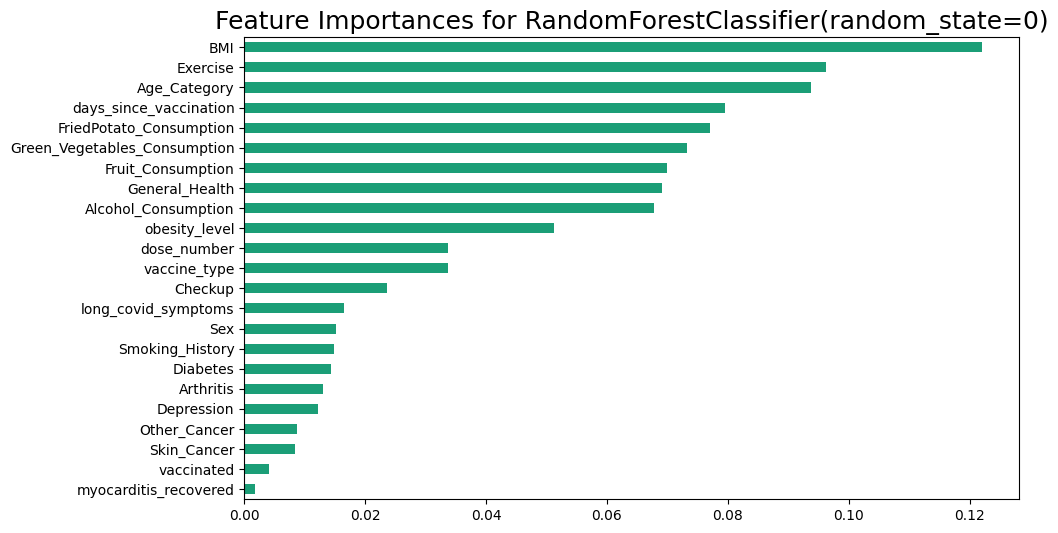

In [69]:
rf_model = RandomForestClassifier(random_state=0)
# Visualizing evaluation Metric Score chart
rf_score = evaluate_model(rf_model, X_smote, X_test_scaled, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['RForest'] = rf_score
score

### Regularization for Random Forest

Random Forest CV Accuracy:  0.7551580720077261

Train ROC AUC: 0.7706516145422805
Test ROC AUC: 0.6710715735991838


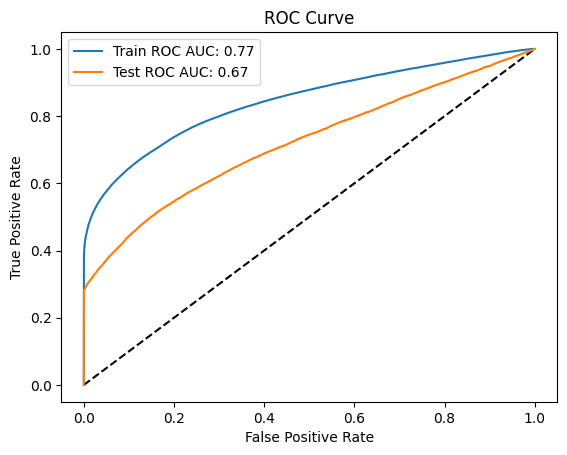


Confusion Matrix:


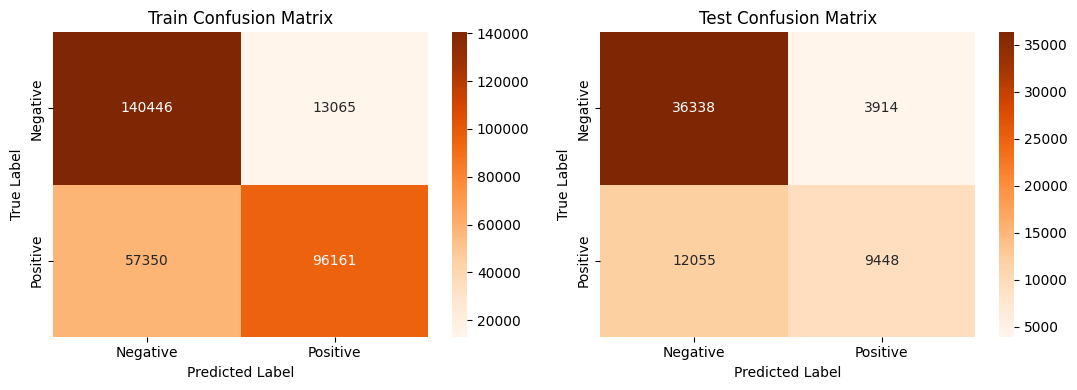


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.710055 | 0.914892 |   0.799563 | 153511        |
| 1            |    0.880386 | 0.626411 |   0.731994 | 153511        |
| accuracy     |    0.770652 | 0.770652 |   0.770652 |      0.770652 |
| macro avg    |    0.79522  | 0.770652 |   0.765779 | 307022        |
| weighted avg |    0.79522  | 0.770652 |   0.765779 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.750894 | 0.902763 |   0.819854 | 40252        |
| 1            |    0.70708  | 0.439381 |   0.541976 | 21503        |
| accuracy     |    0.741414 | 0.741414 |   0.741414 |     0.741414 |
| macro avg    |    0.728987 | 0.671072 |   0.680915 | 61755        |
| weighted avg |    0.73

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF  
Precision Train  0.719497  0.780312  0.999997  0.795220  
Precision Test   0.708877  0.744254  0.751574  0.735638  
Recall Train     0.705223  0.742553  0.999997  0.770652  
Recall Test      0.717351  0.745462  0.745559  0.741414  
Accuracy Train   0.705223  0.742553  0.999997  0.770652  
Accuracy Test    0.717351  0.745462  0.745559  0.741414  
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  
F1 macro Train   0.700351  0.733581  0.999997  0.765779  
F1 macro Test    0.710611  0.723145  0.717428  0.723098

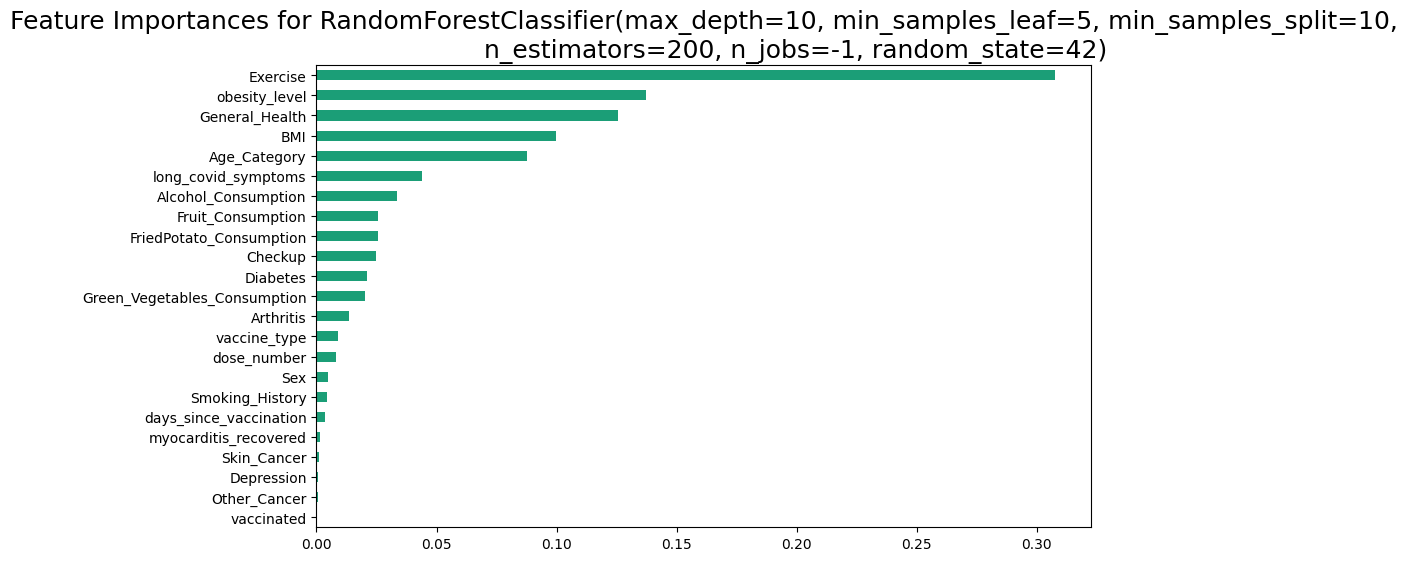

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Cross-validate
cv_scores = cross_val_score(rf, X_smote, y_smote, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: ", cv_scores.mean())

rf.fit(X_smote, y_smote)

rf_tune = evaluate_model(rf, X_smote, X_test_scaled, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['Reg-RF'] = rf_tune
score

# XGBoost


Train ROC AUC: 0.8312010214251748
Test ROC AUC: 0.6586561740280986


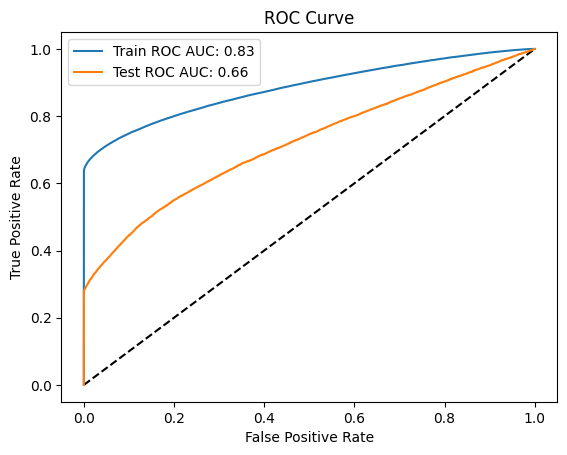


Confusion Matrix:


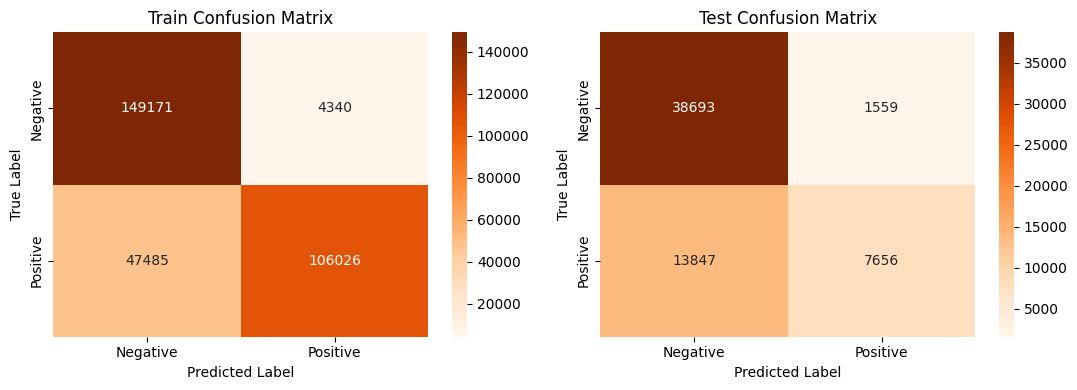


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.758538 | 0.971728 |   0.851999 | 153511        |
| 1            |    0.960676 | 0.690674 |   0.803602 | 153511        |
| accuracy     |    0.831201 | 0.831201 |   0.831201 |      0.831201 |
| macro avg    |    0.859607 | 0.831201 |   0.8278   | 307022        |
| weighted avg |    0.859607 | 0.831201 |   0.8278   | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.736448 | 0.961269 |   0.833973 | 40252       |
| 1            |    0.830819 | 0.356043 |   0.49847  | 21503       |
| accuracy     |    0.75053  | 0.75053  |   0.75053  |     0.75053 |
| macro avg    |    0.783634 | 0.658656 |   0.666221 | 61755       |
| weighted avg |    0.769308 |

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607  
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308  
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201  
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530  
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201  
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530  
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201  
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656  
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800  
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151

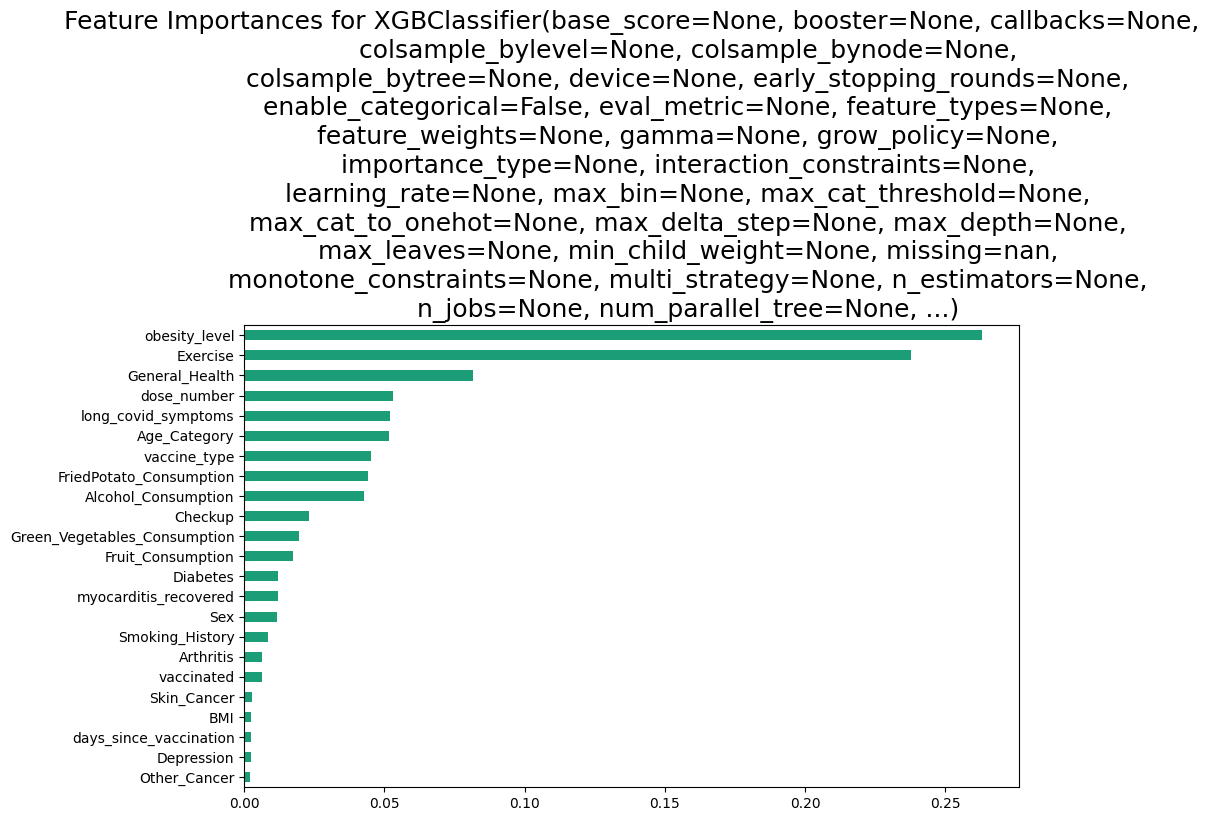

In [71]:
xgb_model = xgb.XGBClassifier()

# Visualizing evaluation Metric Score chart
xgb_score = evaluate_model(xgb_model, X_smote, X_test_scaled, y_smote, y_test)
# Updated Evaluation metric Score Chart
score['XGB'] = xgb_score
score

### Cross- Validation & Hyperparameter Tuning

Fitting 9 folds for each of 10 candidates, totalling 90 fits
Best hyperparameters:  {'n_estimators': np.int64(130), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.06999999999999999)}

Train ROC AUC: 0.8274227905492115
Test ROC AUC: 0.659583463527773


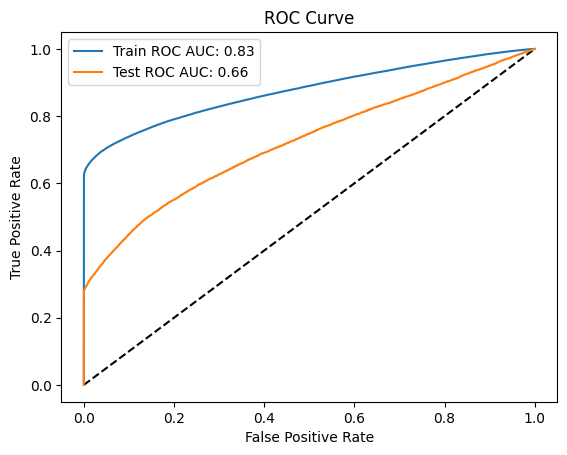


Confusion Matrix:


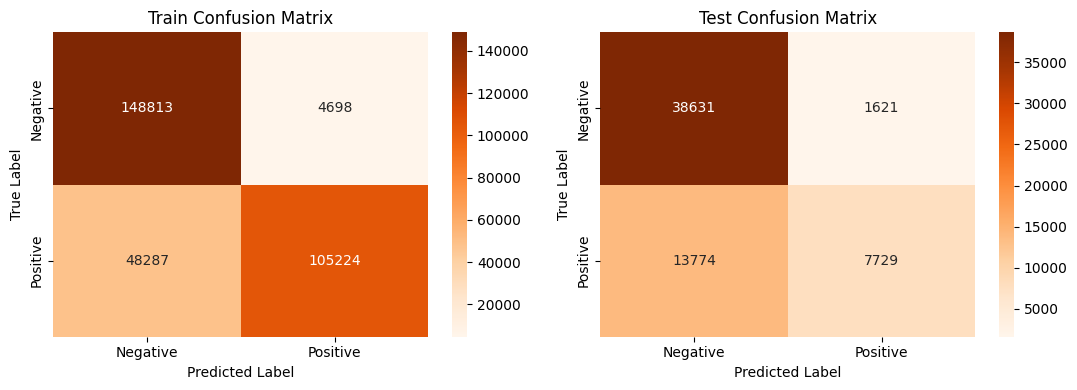


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.755013 | 0.969396 |   0.848878 | 153511        |
| 1            |    0.957261 | 0.685449 |   0.798867 | 153511        |
| accuracy     |    0.827423 | 0.827423 |   0.827423 |      0.827423 |
| macro avg    |    0.856137 | 0.827423 |   0.823873 | 307022        |
| weighted avg |    0.856137 | 0.827423 |   0.823873 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.737162 | 0.959729 |   0.83385  | 40252        |
| 1            |    0.826631 | 0.359438 |   0.501021 | 21503        |
| accuracy     |    0.750708 | 0.750708 |   0.750708 |     0.750708 |
| macro avg    |    0.781897 | 0.659583 |   0.667435 | 61755        |
| weighted avg |    0.76

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  XGB tuned  
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607   0.856137  
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308   0.768315  
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201   0.827423  
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530   0.750708  
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201   0.827423  
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530   0.750708  
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201   0.827423  
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656   0.659583  
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800   0.823873  
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151   0.717959

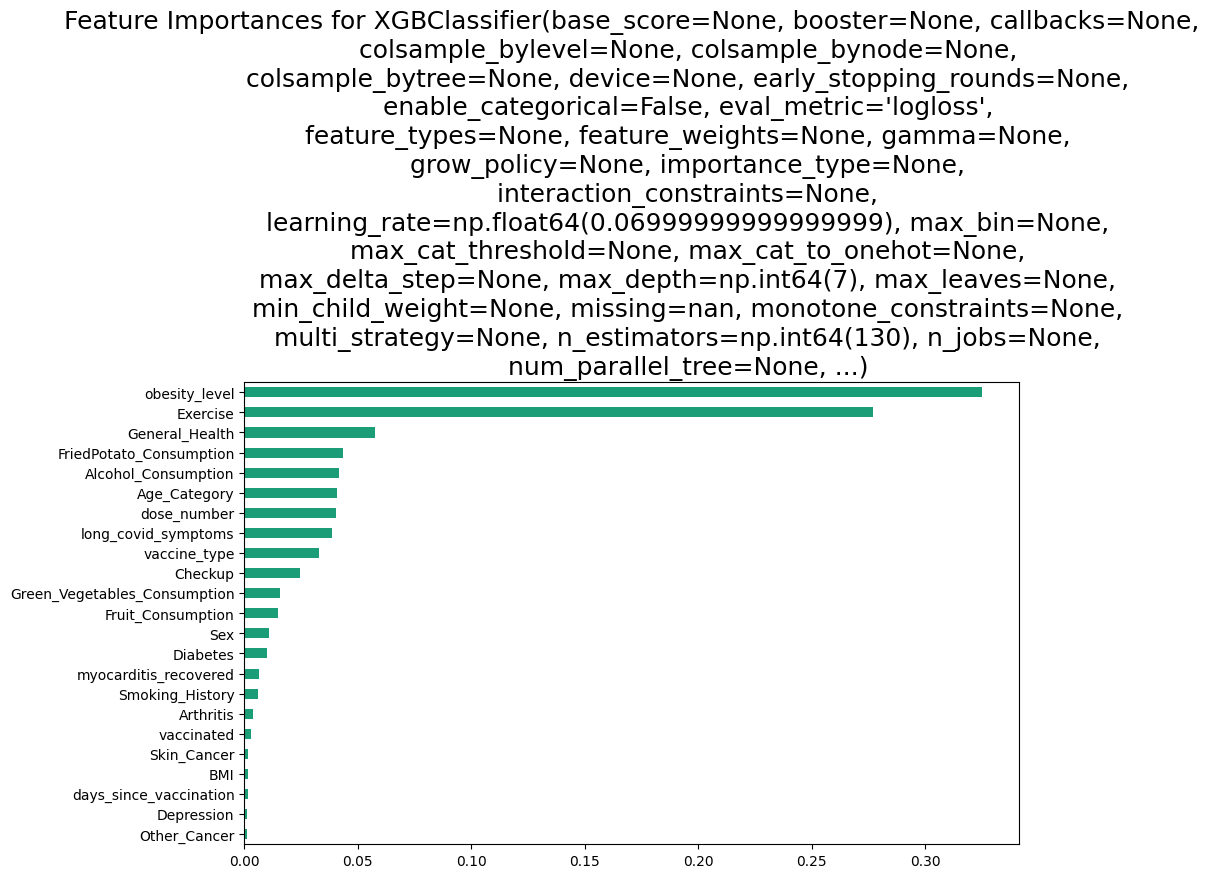

In [72]:

# Define the hyperparameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'max_depth': np.arange(3, 15, 1),
    'n_estimators': np.arange(100, 200, 10)
}

# Initialize the base model
xgb2 = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Setup cross-validation strategy
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb2,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=rskf,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit the search
random_search.fit(X_smote, y_smote)

# Retrieve best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters: ", best_params)

# Initialize and train final model with best parameters
xgb_model2 = xgb.XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Evaluate and store score
xgb2_score = evaluate_model(xgb_model2, X_smote, X_test_scaled, y_smote, y_test)
score['XGB tuned'] = xgb2_score
score


# Navies Bayes

In [73]:
xgb.XGBClassifier(scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


Train ROC AUC: 0.6625290695780759
Test ROC AUC: 0.6489188180269075


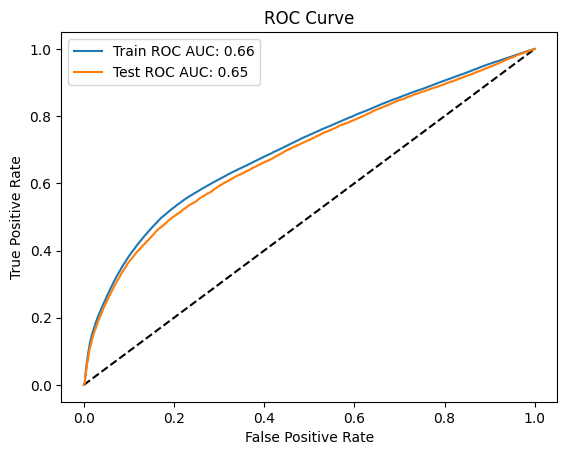


Confusion Matrix:


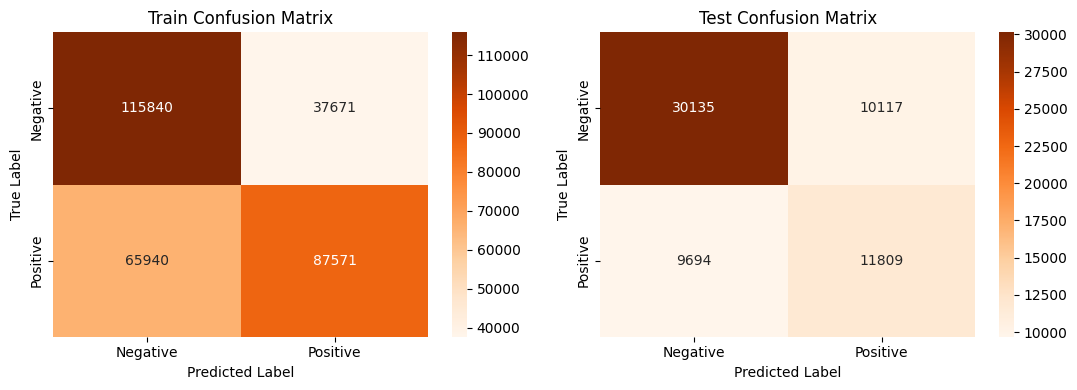


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.637254 | 0.754604 |   0.690982 | 153511        |
| 1            |    0.699214 | 0.570454 |   0.628305 | 153511        |
| accuracy     |    0.662529 | 0.662529 |   0.662529 |      0.662529 |
| macro avg    |    0.668234 | 0.662529 |   0.659644 | 307022        |
| weighted avg |    0.668234 | 0.662529 |   0.659644 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.75661  | 0.748658 |   0.752613 | 40252      |
| 1            |    0.538584 | 0.549179 |   0.54383  | 21503      |
| accuracy     |    0.6792   | 0.6792   |   0.6792   |     0.6792 |
| macro avg    |    0.647597 | 0.648919 |   0.648222 | 61755      |
| weighted avg |    0.680693 | 0.679

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  XGB tuned  \
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607   0.856137   
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308   0.768315   
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656   0.659583   
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800   0.823873   
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151   0.717959   

                 Naive Bayes  
Precision Train     0.668234  
Precision Test      0.680693  
Recall Train        0.662529  
Recall Test         0.679200  
Accuracy Train      0.662529  
Accuracy Test       0.679200  
ROC-AUC Train       0.662529  
ROC-AUC Test        0.648919  
F1 macro Train      0.659644  
F1 macro Test       0.679915

In [74]:
nb_model = GaussianNB()
# Visualizing evaluation Metric Score chart
nb_score = evaluate_model(nb_model, X_smote, X_test_scaled, y_smote, y_test)

# Updated Evaluation metric Score Chart
score['Naive Bayes'] = nb_score
score

### Cross- Validation & Hyperparameter Tuning

Best hyperparameters:  {'var_smoothing': np.float64(0.1873817422860384)}

Train ROC AUC: 0.6641217893180293
Test ROC AUC: 0.6506148166056241


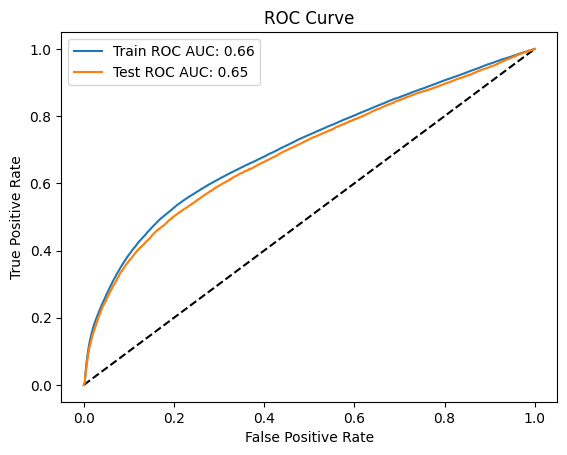


Confusion Matrix:


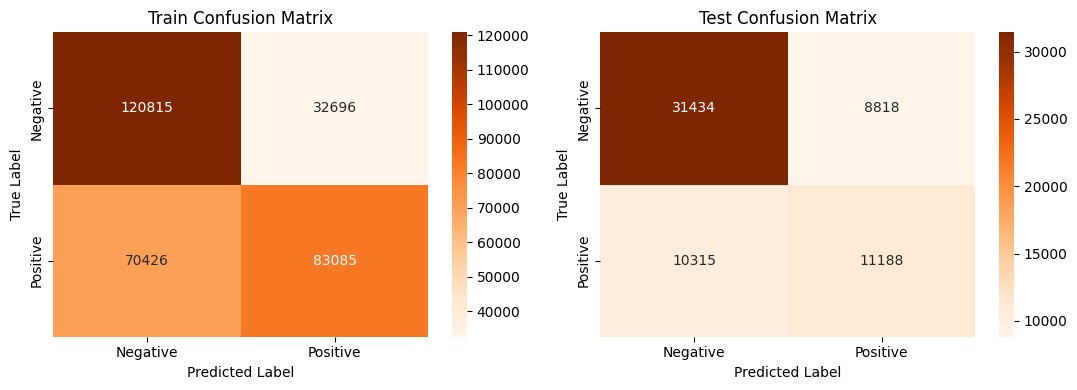


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.631742 | 0.787012 |   0.700881 | 153511        |
| 1            |    0.717605 | 0.541232 |   0.617063 | 153511        |
| accuracy     |    0.664122 | 0.664122 |   0.664122 |      0.664122 |
| macro avg    |    0.674673 | 0.664122 |   0.658972 | 307022        |
| weighted avg |    0.674673 | 0.664122 |   0.658972 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.752928 | 0.78093  |   0.766674 | 40252        |
| 1            |    0.559232 | 0.520299 |   0.539064 | 21503        |
| accuracy     |    0.690179 | 0.690179 |   0.690179 |     0.690179 |
| macro avg    |    0.65608  | 0.650615 |   0.652869 | 61755        |
| weighted avg |    0.68

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  XGB tuned  \
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607   0.856137   
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308   0.768315   
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656   0.659583   
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800   0.823873   
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151   0.717959   

                 Naive Bayes  NB-tuned  
Precision Train     0.668234  0.674673  
Precision Test      0.680693  0.685484  
Recall Train        0.662529  0.664122  
Recall Test         0.679200  0.690179  
Accuracy Train      0.662529  0.664122  
Accuracy Test       0.679200  0.690179  
ROC-AUC Train       0.662529  0.664122  
ROC-AUC Test        0.648919  0.650615  
F1 macro Train      0.659644  0.658972  
F1 macro Test       0.679915  0.687420

In [75]:
# Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Define the hyperparameter grid
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Initialize the model
naive = GaussianNB()

# repeated stratified kfold
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=0)

# Initialize GridSearchCV
GridSearch = GridSearchCV(naive, param_grid, cv=rskf, n_jobs=-1)

# Fit the GridSearchCV to the training data
GridSearch.fit(X_smote, y_smote)

# Select the best hyperparameters
best_params = GridSearch.best_params_
print("Best hyperparameters: ", best_params)

# Initiate model with best parameters
nb_model2 = GaussianNB(var_smoothing = best_params['var_smoothing'])

# Visualizing evaluation Metric Score chart
nb2_score = evaluate_model(nb_model2, X_smote, X_test_scaled, y_smote, y_test)

score['NB-tuned']= nb2_score
score

# Neural Network


Train ROC AUC: 0.7061448365263726
Test ROC AUC: 0.6660779994004103


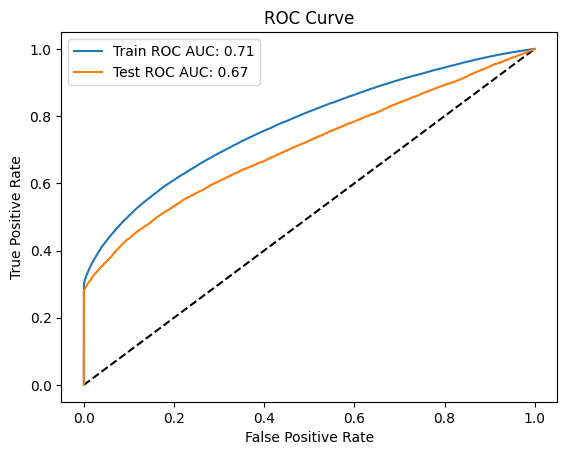


Confusion Matrix:


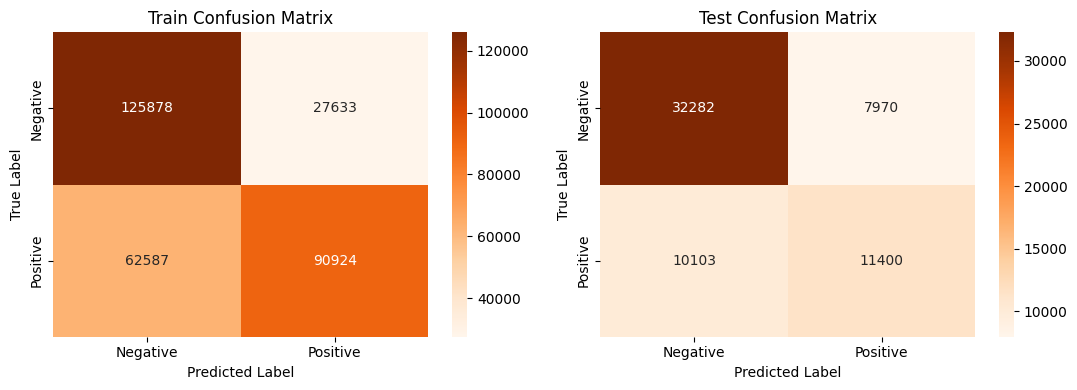


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.667912 | 0.819993 |   0.73618  | 153511        |
| 1            |    0.766922 | 0.592296 |   0.668392 | 153511        |
| accuracy     |    0.706145 | 0.706145 |   0.706145 |      0.706145 |
| macro avg    |    0.717417 | 0.706145 |   0.702286 | 307022        |
| weighted avg |    0.717417 | 0.706145 |   0.702286 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.761637 | 0.801997 |   0.781297 | 40252        |
| 1            |    0.588539 | 0.530159 |   0.557825 | 21503        |
| accuracy     |    0.707344 | 0.707344 |   0.707344 |     0.707344 |
| macro avg    |    0.675088 | 0.666078 |   0.669561 | 61755        |
| weighted avg |    0.70

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  XGB tuned  \
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607   0.856137   
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308   0.768315   
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656   0.659583   
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800   0.823873   
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151   0.717959   

                 Naive Bayes  NB-tuned        NN  
Precision Train     0.668234  0.674673  0.717417  
Precision Test      0.680693  0.685484  0.701365  
Recall Train        0.662529  0.664122  0.706145  
Recall Test         0.679200  0.690179  0.707344  
Accuracy Train      0.662529  0.664122  0.706145  
Accuracy Test       0.679200  0.690179  0.707344  
ROC-AUC Train       0.662529  0.664122  0.706145  
ROC-AUC Test        0.648919  0.650615  0.666078  
F1 macro Train      0.659644  0.658972  0.702286  
F1 macro Test       0.679915  0.687420  0.703484

In [76]:
nn_model = MLPClassifier(random_state=0)
# Visualizing evaluation Metric Score chart
neural_score = evaluate_model(nn_model, X_smote, X_test_scaled, y_smote, y_test)
# Updated Evaluation metric Score Chart
score['NN'] = neural_score
score

### Cross- Validation & Hyperparameter Tuning

Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Best hyperparameters (Bayesian Optimization): OrderedDict([('alpha', 0.00796881371691501), ('hidden_layer_sizes', 78)])

Train ROC AUC: 0.7016109594752168
Test ROC AUC: 0.6687870618008467


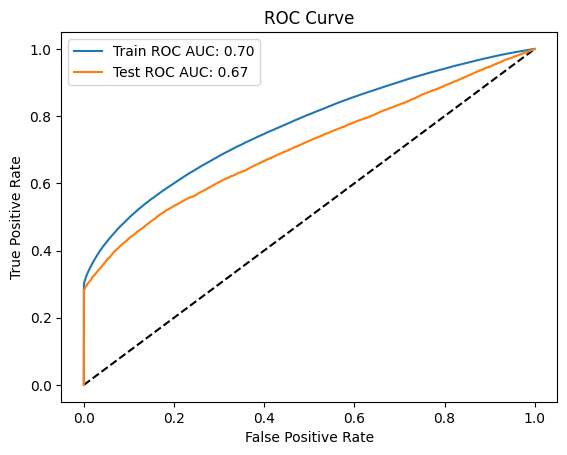


Confusion Matrix:


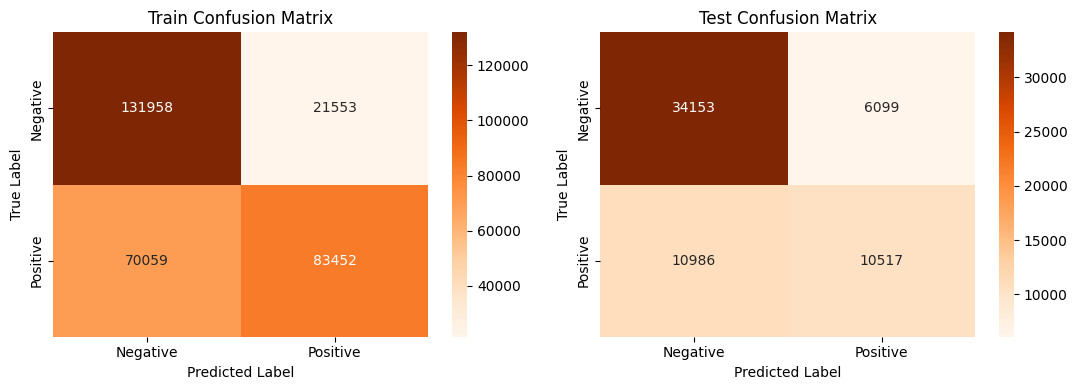


Train Classification Report:
|              |   precision |   recall |   f1-score |       support |
|:-------------|------------:|---------:|-----------:|--------------:|
| 0            |    0.653202 | 0.8596   |   0.742321 | 153511        |
| 1            |    0.794743 | 0.543622 |   0.645623 | 153511        |
| accuracy     |    0.701611 | 0.701611 |   0.701611 |      0.701611 |
| macro avg    |    0.723973 | 0.701611 |   0.693972 | 307022        |
| weighted avg |    0.723973 | 0.701611 |   0.693972 | 307022        |

Test Classification Report:
|              |   precision |   recall |   f1-score |      support |
|:-------------|------------:|---------:|-----------:|-------------:|
| 0            |    0.756618 | 0.84848  |   0.79992  | 40252        |
| 1            |    0.632944 | 0.489095 |   0.551798 | 21503        |
| accuracy     |    0.723342 | 0.723342 |   0.723342 |     0.723342 |
| macro avg    |    0.694781 | 0.668787 |   0.675859 | 61755        |
| weighted avg |    0.71

Log Reg  Tuned LR       KNN  LinearSVM  SVM tuned        DT  \
Precision Train  0.648310  0.648314  0.846750   0.723867   0.647591  1.000000   
Precision Test   0.666355  0.666355  0.649033   0.713158   0.665596  0.650496   
Recall Train     0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Recall Test      0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
Accuracy Train   0.646758  0.646761  0.839660   0.731400   0.646074  1.000000   
Accuracy Test    0.652514  0.652514  0.624937   0.722600   0.651494  0.646474   
ROC-AUC Train    0.646758  0.646761  0.839660   0.663728   0.646074  1.000000   
ROC-AUC Test     0.635466  0.635466  0.616056   0.652688   0.634629  0.616135   
F1 macro Train   0.645831  0.645835  0.838836   0.713539   0.645162  1.000000   
F1 macro Test    0.657545  0.657545  0.632368   0.703611   0.656599  0.648311   

                   Reg DT  DT Tuned   RForest    Reg-RF       XGB  XGB tuned  \
Precision Train  0.719497  0.780312  0.999997  0.795220  0.859607   0.856137   
Precision Test   0.708877  0.744254  0.751574  0.735638  0.769308   0.768315   
Recall Train     0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Recall Test      0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
Accuracy Train   0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
Accuracy Test    0.717351  0.745462  0.745559  0.741414  0.750530   0.750708   
ROC-AUC Train    0.705223  0.742553  0.999997  0.770652  0.831201   0.827423   
ROC-AUC Test     0.669444  0.668675  0.660551  0.671072  0.658656   0.659583   
F1 macro Train   0.700351  0.733581  0.999997  0.765779  0.827800   0.823873   
F1 macro Test    0.710611  0.723145  0.717428  0.723098  0.717151   0.717959   

                 Naive Bayes  NB-tuned        NN  Neural Network BayesSearch  \
Precision Train     0.668234  0.674673  0.717417                    0.723973   
Precision Test      0.680693  0.685484  0.701365                    0.713555   
Recall Train        0.662529  0.664122  0.706145                    0.701611   
Recall Test         0.679200  0.690179  0.707344                    0.723342   
Accuracy Train      0.662529  0.664122  0.706145                    0.701611   
Accuracy Test       0.679200  0.690179  0.707344                    0.723342   
ROC-AUC Train       0.662529  0.664122  0.706145                    0.701611   
ROC-AUC Test        0.648919  0.650615  0.666078                    0.668787   
F1 macro Train      0.659644  0.658972  0.702286                    0.693972   
F1 macro Test       0.679915  0.687420  0.703484                    0.713525   

                 Tuned NN  
Precision Train  0.723973  
Precision Test   0.713555  
Recall Train     0.701611  
Recall Test      0.723342  
Accuracy Train   0.701611  
Accuracy Test    0.723342  
ROC-AUC Train    0.701611  
ROC-AUC Test     0.668787  
F1 macro Train   0.693972  
F1 macro Test    0.713525

In [77]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# Define search space for Bayesian optimization
search_spaces = {
    'hidden_layer_sizes': Integer(10, 100),  # This means (10,) to (100,)
    'alpha': Real(1e-5, 1e-2, prior='log-uniform')
}

# Initialize model
mlp_bayes = MLPClassifier(random_state=0, max_iter=1000)

# Cross-validation strategy
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=mlp_bayes,
    search_spaces=search_spaces,
    n_iter=10,  # You can increase for better results
    scoring='roc_auc',
    cv=rskf,
    n_jobs=-1,
    random_state=0,
    verbose=1
)

# Fit to SMOTE-balanced training data
bayes_search.fit(X_smote, y_smote)

# Get best parameters
best_params_bayes = bayes_search.best_params_
print("Best hyperparameters (Bayesian Optimization):", best_params_bayes)

# Train final model with best params
mlp_bayes_model = MLPClassifier(
    hidden_layer_sizes=(best_params_bayes['hidden_layer_sizes'],),
    alpha=best_params_bayes['alpha'],
    random_state=0,     
    max_iter=1000
)
mlp_bayes_model.fit(X_smote, y_smote)

# Evaluate and store
neural_bayes_score = evaluate_model(mlp_bayes_model, X_smote, X_test_scaled, y_smote, y_test)
score['Neural Network BayesSearch'] = neural_bayes_score

# Optional: print all scores
for model, metrics in score.items():
    print(f"{model}: {metrics}")
score['Tuned NN']= neural_bayes_score
score

## Visual comparision of the models

### Precision Score

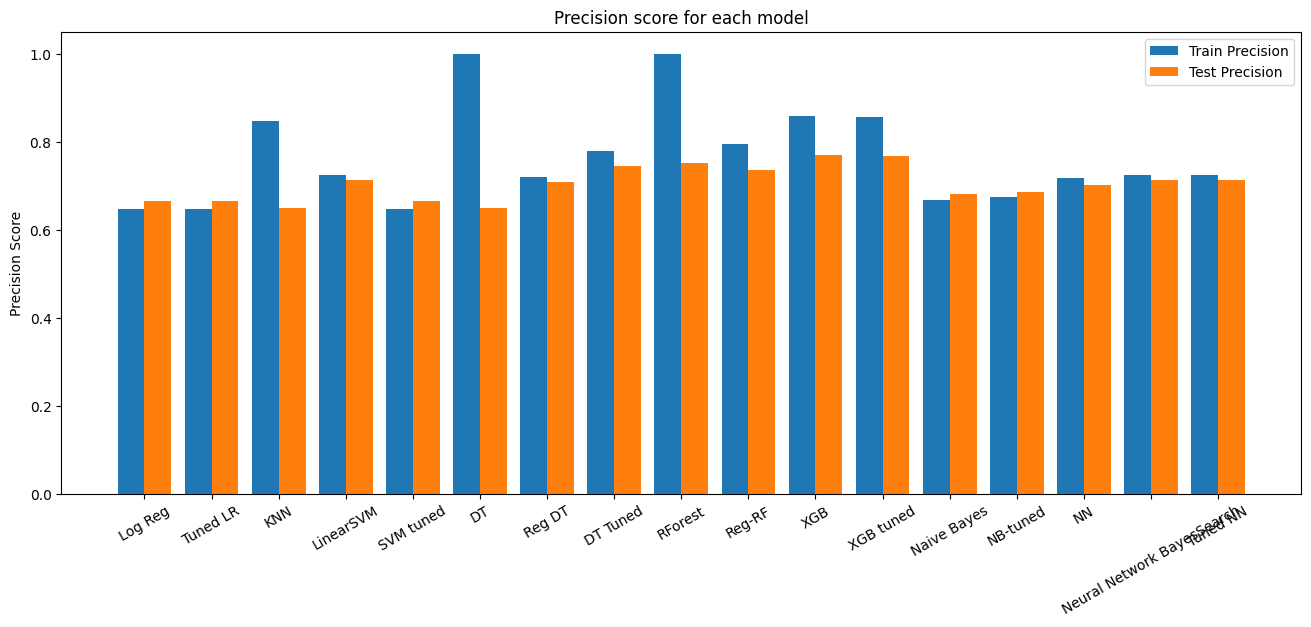

In [78]:
models = list(score.columns)
train = score.iloc[0,:]
test = score.iloc[1,:]

X_axis = np.arange(len(models))

plt.figure(figsize=(16,6))
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train Precision')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test Precision')

# Set labels
plt.xticks(X_axis,models, rotation=30)
plt.ylabel("Precision Score")
plt.title("Precision score for each model")
plt.legend()
plt.show()

### Recall Score

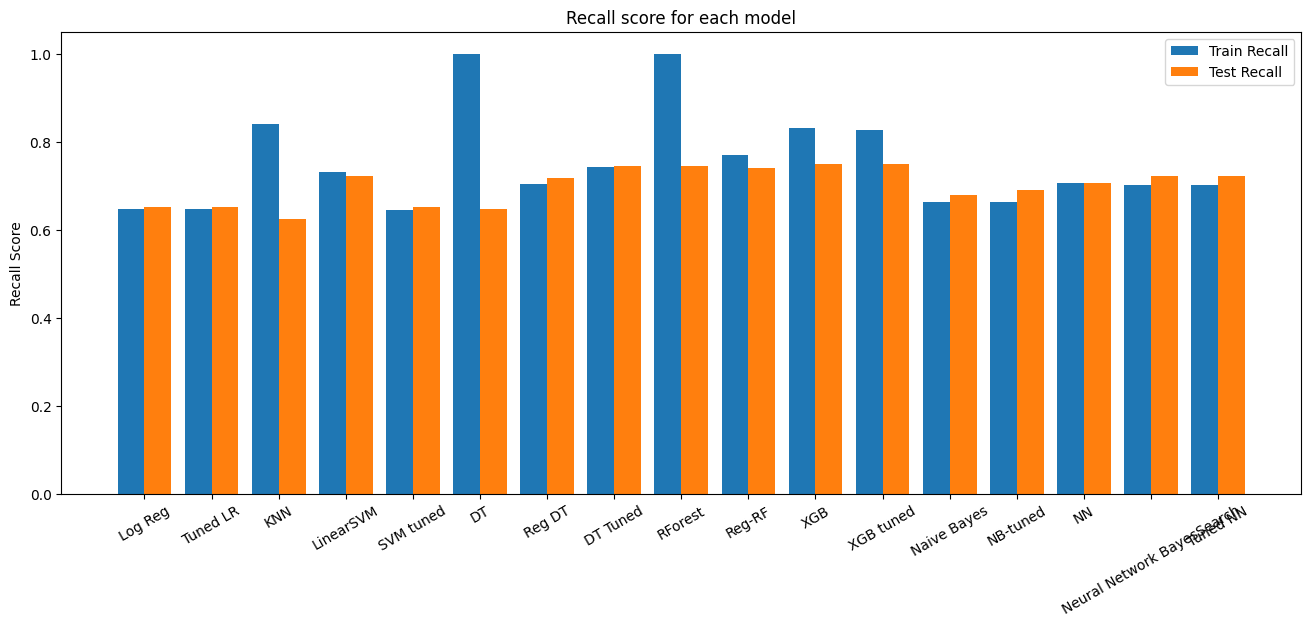

In [79]:

models = list(score.columns)
train = score.iloc[2,:]
test = score.iloc[3,:]

X_axis = np.arange(len(models))

plt.figure(figsize=(16,6))
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train Recall')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test Recall')

# Set labels
plt.xticks(X_axis,models, rotation=30)
plt.ylabel("Recall Score")
plt.title("Recall score for each model")
plt.legend()
plt.show()

### Accuracy Score

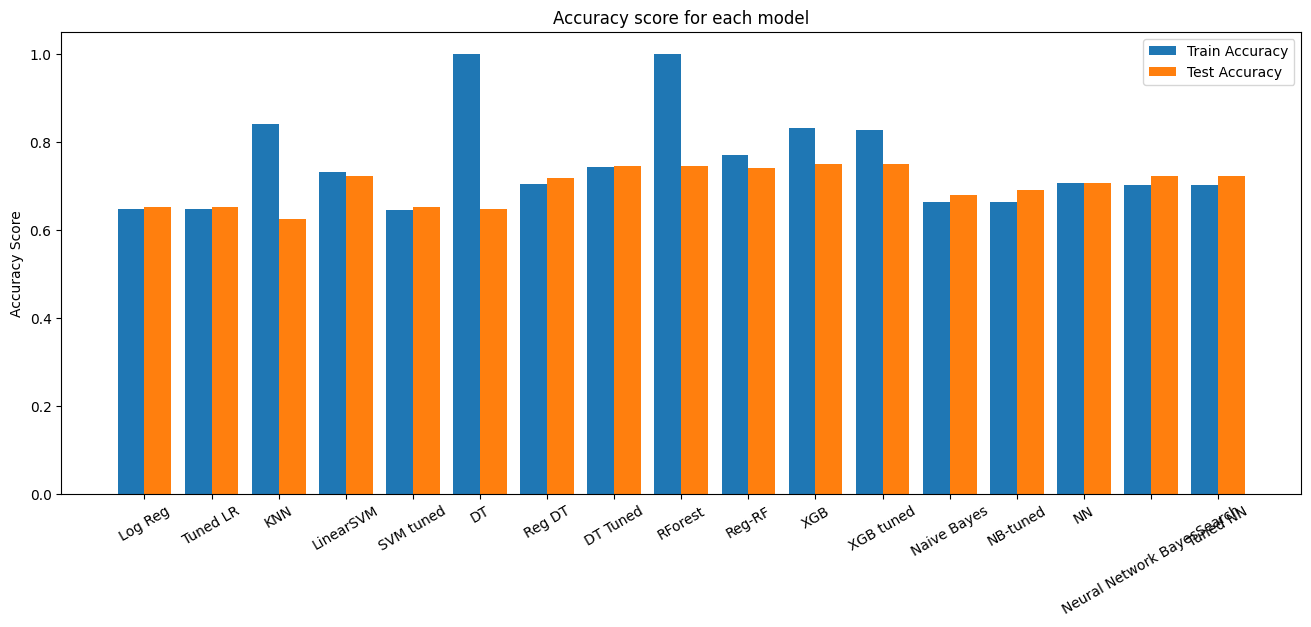

In [80]:
models = list(score.columns)
train = score.iloc[4,:]
test = score.iloc[5,:]

X_axis = np.arange(len(models))

plt.figure(figsize=(16,6))
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train Accuracy')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test Accuracy')

# Set labels
plt.xticks(X_axis,models, rotation=30)
plt.ylabel("Accuracy Score")
plt.title("Accuracy score for each model")
plt.legend()
plt.show()

### ROC-AUC Score

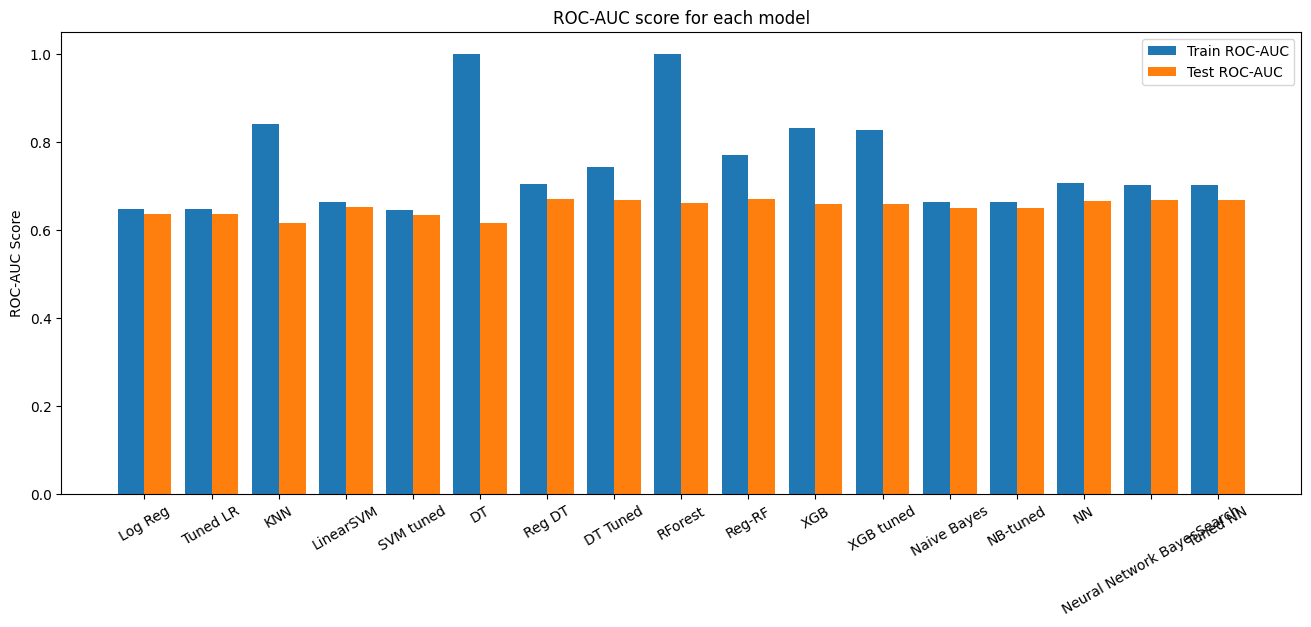

In [81]:
models = list(score.columns)
train = score.iloc[6,:]
test = score.iloc[7,:]

X_axis = np.arange(len(models))

plt.figure(figsize=(16,6))
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train ROC-AUC')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test ROC-AUC')

# Set labels
plt.xticks(X_axis,models, rotation=30)
plt.ylabel("ROC-AUC Score")
plt.title("ROC-AUC score for each model")
plt.legend()
plt.show()

### F1 macro Score

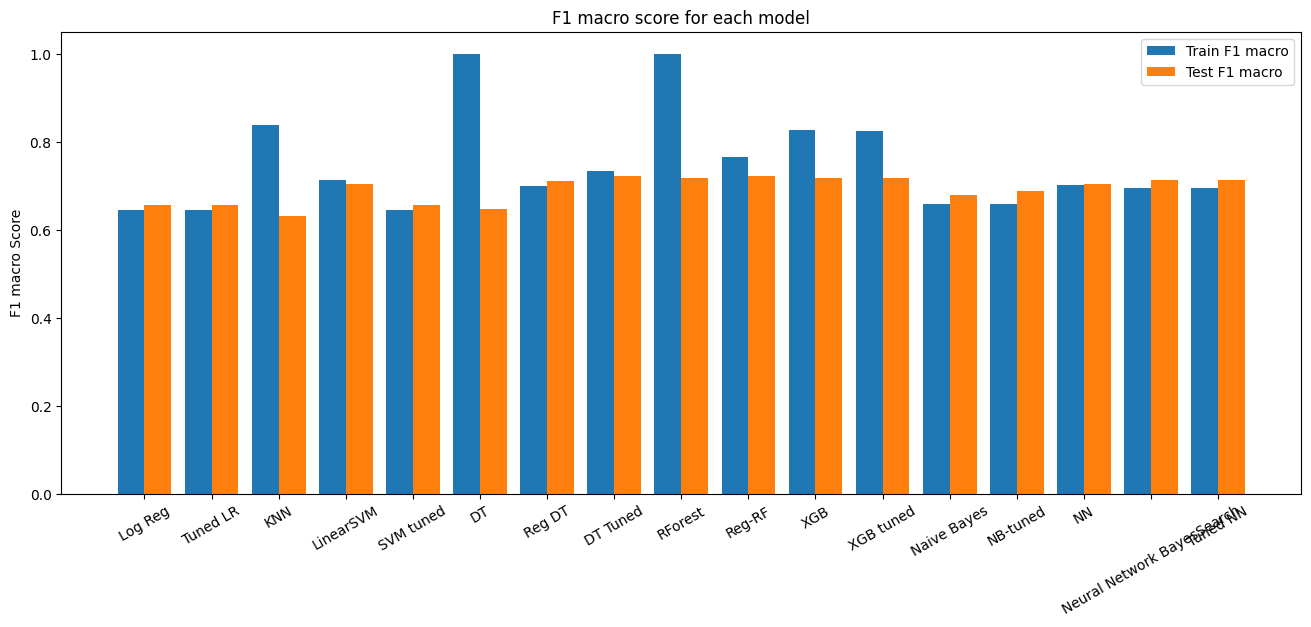

In [82]:
models = list(score.columns)
train = score.iloc[8,:]
test = score.iloc[9,:]

X_axis = np.arange(len(models))

plt.figure(figsize=(16,6))
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train F1 macro')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test F1 macro')

# Set labels
plt.xticks(X_axis,models, rotation=30)
plt.ylabel("F1 macro Score")
plt.title("F1 macro score for each model")
plt.legend()
plt.show()

#### Removing the overfitted models which have recall, ROC-AUC, f1 scores for train as 1

In [83]:

score_t = score.transpose()            #taking transpose of the score dataframe to create new difference column
remove_models = score_t[score_t['Recall Train']>=0.95].index  #creating a list of models which have 1 for train and score_t['Accuracy Train']==1.0 and score_t['ROC-AUC Train']==1.0 and score_t['F1 macro Train']==1.0
remove_models

adj = score_t.drop(remove_models)                     #creating a new dataframe with required models
adj

Precision Train  Precision Test  Recall Train  \
Log Reg                            0.648310        0.666355      0.646758   
Tuned LR                           0.648314        0.666355      0.646761   
KNN                                0.846750        0.649033      0.839660   
LinearSVM                          0.723867        0.713158      0.731400   
SVM tuned                          0.647591        0.665596      0.646074   
Reg DT                             0.719497        0.708877      0.705223   
DT Tuned                           0.780312        0.744254      0.742553   
Reg-RF                             0.795220        0.735638      0.770652   
XGB                                0.859607        0.769308      0.831201   
XGB tuned                          0.856137        0.768315      0.827423   
Naive Bayes                        0.668234        0.680693      0.662529   
NB-tuned                           0.674673        0.685484      0.664122   
NN                                 0.717417        0.701365      0.706145   
Neural Network BayesSearch         0.723973        0.713555      0.701611   
Tuned NN                           0.723973        0.713555      0.701611   

                            Recall Test  Accuracy Train  Accuracy Test  \
Log Reg                        0.652514        0.646758       0.652514   
Tuned LR                       0.652514        0.646761       0.652514   
KNN                            0.624937        0.839660       0.624937   
LinearSVM                      0.722600        0.731400       0.722600   
SVM tuned                      0.651494        0.646074       0.651494   
Reg DT                         0.717351        0.705223       0.717351   
DT Tuned                       0.745462        0.742553       0.745462   
Reg-RF                         0.741414        0.770652       0.741414   
XGB                            0.750530        0.831201       0.750530   
XGB tuned                      0.750708        0.827423       0.750708   
Naive Bayes                    0.679200        0.662529       0.679200   
NB-tuned                       0.690179        0.664122       0.690179   
NN                             0.707344        0.706145       0.707344   
Neural Network BayesSearch     0.723342        0.701611       0.723342   
Tuned NN                       0.723342        0.701611       0.723342   

                            ROC-AUC Train  ROC-AUC Test  F1 macro Train  \
Log Reg                          0.646758      0.635466        0.645831   
Tuned LR                         0.646761      0.635466        0.645835   
KNN                              0.839660      0.616056        0.838836   
LinearSVM                        0.663728      0.652688        0.713539   
SVM tuned                        0.646074      0.634629        0.645162   
Reg DT                           0.705223      0.669444        0.700351   
DT Tuned                         0.742553      0.668675        0.733581   
Reg-RF                           0.770652      0.671072        0.765779   
XGB                              0.831201      0.658656        0.827800   
XGB tuned                        0.827423      0.659583        0.823873   
Naive Bayes                      0.662529      0.648919        0.659644   
NB-tuned                         0.664122      0.650615        0.658972   
NN                               0.706145      0.666078        0.702286   
Neural Network BayesSearch       0.701611      0.668787        0.693972   
Tuned NN                         0.701611      0.668787        0.693972   

                            F1 macro Test  
Log Reg                          0.657545  
Tuned LR                         0.657545  
KNN                              0.632368  
LinearSVM                        0.703611  
SVM tuned                        0.656599  
Reg DT                           0.710611  
DT Tuned                         0.723145  
Reg-RF                           0.723098  
XGB          

In [84]:
def select_best_model(df, metrics):

    best_models = {}
    for metric in metrics:
        max_test = df[metric + ' Test'].max()
        best_model_test = df[df[metric + ' Test'] == max_test].index[0]
        best_model = best_model_test
        best_models[metric] = best_model
    return best_models

metrics = ['Precision','Recall', 'Accuracy', 'ROC-AUC', 'F1 macro']

best_models = select_best_model(adj, metrics)
print("The best models are:")
for metric, best_model in best_models.items():
    print(f"{metric}: {best_model} - {adj[metric+' Test'][best_model].round(4)}")

The best models are:
Precision: XGB - 0.7693
Recall: XGB tuned - 0.7507
Accuracy: XGB tuned - 0.7507
ROC-AUC: Reg-RF - 0.6711
F1 macro: DT Tuned - 0.7231


In [85]:
# Take recall as the primary evaluation metric
score_smpl = score.transpose()
remove_overfitting_models = score_smpl[score_smpl['Recall Train']>=0.95].index
remove_overfitting_models
new_score = score_smpl.drop(remove_overfitting_models)
new_score = new_score.drop(['Precision Train','Precision Test','Accuracy Train','Accuracy Test','ROC-AUC Train','ROC-AUC Test','F1 macro Train','F1 macro Test'], axis=1)
new_score.index.name = 'Classification Model'
print(new_score.to_markdown())

| Classification Model       |   Recall Train |   Recall Test |
|:---------------------------|---------------:|--------------:|
| Log Reg                    |       0.646758 |      0.652514 |
| Tuned LR                   |       0.646761 |      0.652514 |
| KNN                        |       0.83966  |      0.624937 |
| LinearSVM                  |       0.7314   |      0.7226   |
| SVM tuned                  |       0.646074 |      0.651494 |
| Reg DT                     |       0.705223 |      0.717351 |
| DT Tuned                   |       0.742553 |      0.745462 |
| Reg-RF                     |       0.770652 |      0.741414 |
| XGB                        |       0.831201 |      0.75053  |
| XGB tuned                  |       0.827423 |      0.750708 |
| Naive Bayes                |       0.662529 |      0.6792   |
| NB-tuned                   |       0.664122 |      0.690179 |
| NN                         |       0.706145 |      0.707344 |
| Neural Network BayesSearch |       0.7

## **SHAP (SHapley Additive exPlanations)**

In [90]:
X = pd.read_csv(r'C:\Users\megha\Downloads\project1\data\X.csv')

In [91]:
X

General_Health  Checkup  Exercise  Skin_Cancer  Other_Cancer  \
0                    0        3         0            0             0   
1                    3        4         0            0             0   
2                    3        4         1            0             0   
3                    0        4         1            0             0   
4                    2        4         0            0             0   
...                ...      ...       ...          ...           ...   
308769               3        4         1            0             0   
308770               1        2         1            0             0   
308771               3        1         1            0             0   
308772               3        4         1            0             0   
308773               4        4         1            0             0   

        Depression  Diabetes  Arthritis  Sex  Age_Category  ...  \
0                0         0          1    1            10  ...   
1                0         2          0    1            10  ...   
2                0         2          0    1             8  ...   
3                0         2          0    0            11  ...   
4                0         0          0    0            12  ...   
...            ...       ...        ...  ...           ...  ...   
308769           0         0          0    0             1  ...   
308770           0         2          0    0             9  ...   
308771           1         1          0    1             2  ...   
308772           0         0          0    0             9  ...   
308773           0         0          0    1             5  ...   

        Fruit_Consumption  Green_Vegetables_Consumption  \
0                      30                            16   
1                      30                             0   
2                      12                             3   
3                      30                            30   
4                       8                             4   
...                   ...                           ...   
308769                 30                             8   
308770                 15                            60   
308771                 40                             8   
308772                 30                            12   
308773                  5                            12   

        FriedPotato_Consumption  vaccinated  dose_number  vaccine_type  \
0                            12           1            1             1   
1                             4           1            3             1   
2                            16           1            3             3   
3                             8           1            3             3   
4                             0           1            1             1   
...                         ...         ...          ...           ...   
308769                        0           1            1             1   
308770                        4           1            1             2   
308771                        4           1            2             3   
308772                        0           1            3             2   
308773                        1           0            0             0   

        days_since_vaccination  long_covid_symptoms  myocarditis_recovered  \
0                          241                    0                      0   
1                           79                    0                      0   
2                          249                    0                      0   
3                          223                    1                      0   
4                          338                    0                      0   
...                        ...                  ...                    ...   
308769                       8                    0                      0   
308770                     305                    0                      0   
308771                     280        

In [ ]:
import shap

# Summarize the background dataset using k-means clustering
X_summary = shap.kmeans(X, 100)

# Create an explainer object
explainer = shap.KernelExplainer(xgb_model2.predict_proba, X_summary)

In [104]:
shap_values = explainer.shap_values(X_test)
shap_values_class1 = shap_values[1]

  0%|          | 0/61755 [00:00<?, ?it/s]

In [ ]:

# Ensure X_test is a DataFrame (with matching feature names)
X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Or use original feature columns


In [ ]:

print("Shape of shap_values_class1:", np.array(shap_values[1]).shape)
print("Shape of X_test_df:", X_test_df.shape)


Shape of shap_values_class1: (23, 2)
Shape of X_test_df: (61755, 23)


In [109]:
# Check the full shape of shap_values (should be a list of arrays)
print(type(shap_values))             # Should be list
print(len(shap_values))              # Should be 2 for binary classification
print(np.array(shap_values[0]).shape)  # Should be (61755, 23)
print(np.array(shap_values[1]).shape)


<class 'numpy.ndarray'>
61755
(23, 2)
(23, 2)


In [111]:
explainer = shap.KernelExplainer(xgb_model2.predict_proba, X_summary)


In [112]:
preds = xgb_model2.predict_proba(X_test[:5])
print(preds.shape)  # Must be (5, 2)


(5, 2)


In [113]:
shap_values = explainer.shap_values(X_test)


  0%|          | 0/61755 [00:00<?, ?it/s]

In [114]:
print(f"shap_values type: {type(shap_values)}")
print(f"Length (number of classes): {len(shap_values)}")
print(f"Shape of shap_values[0]: {np.array(shap_values[0]).shape}")
print(f"Shape of shap_values[1]: {np.array(shap_values[1]).shape}")
print(f"Shape of X_test_df: {X_test_df.shape}")


shap_values type: <class 'numpy.ndarray'>
Length (number of classes): 61755
Shape of shap_values[0]: (23, 2)
Shape of shap_values[1]: (23, 2)
Shape of X_test_df: (61755, 23)


In [ ]:
print("type:", type(shap_values))
print("shape:", np.shape(shap_values))
shap_values_class1 = shap_values[:, :, 1] 

type: <class 'numpy.ndarray'>
shape: (61755, 23, 2)


This SHAP summary plot shows which features most influenced your model's predictions, and how they influenced it — for one of the predicted classes ( CHD_Risk = 1 ).
Y-Axis: Features-The features are sorted top-to-bottom by average impact on the model output (i.e., the mean SHAP value, in absolute terms).Top = most important ;Bottom = least important
X-Axis: SHAP value- Positive SHAP value → pushes the model output toward predicting class 1 (e.g., CHD risk).
Negative SHAP value → pushes it toward class 0.

Color Feature value
Each dot is a person (a row in your data), and color represents the value of the feature:
Red = high value
Blue = low value

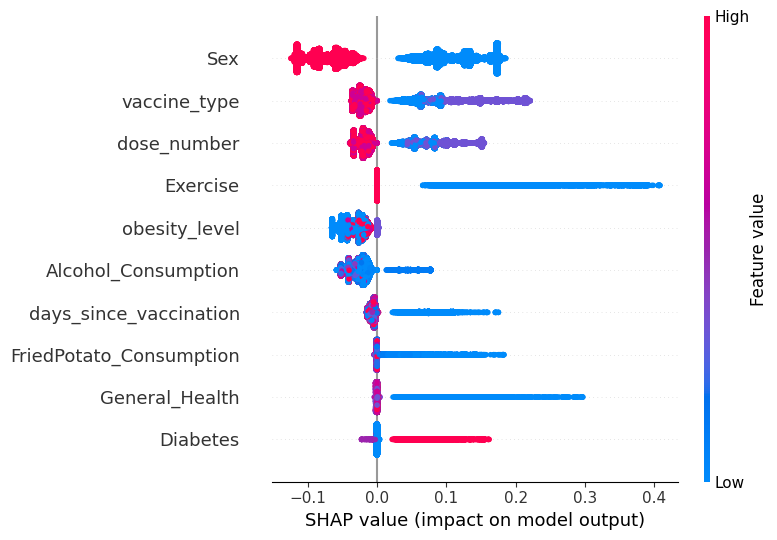

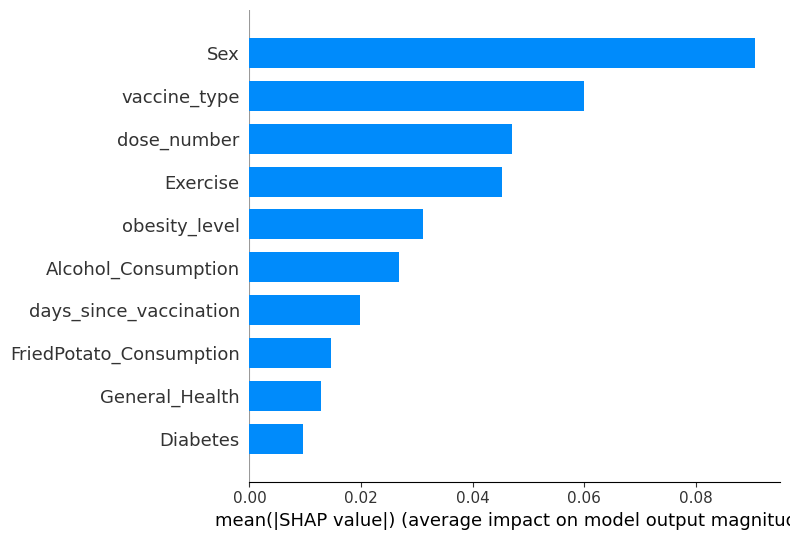

In [118]:
shap.summary_plot(shap_values_class1, X_test_df, feature_names=X_test_df.columns.tolist(), max_display=10)
shap.summary_plot(shap_values_class1, X_test_df, plot_type="bar", feature_names=X_test_df.columns.tolist(), max_display=10)


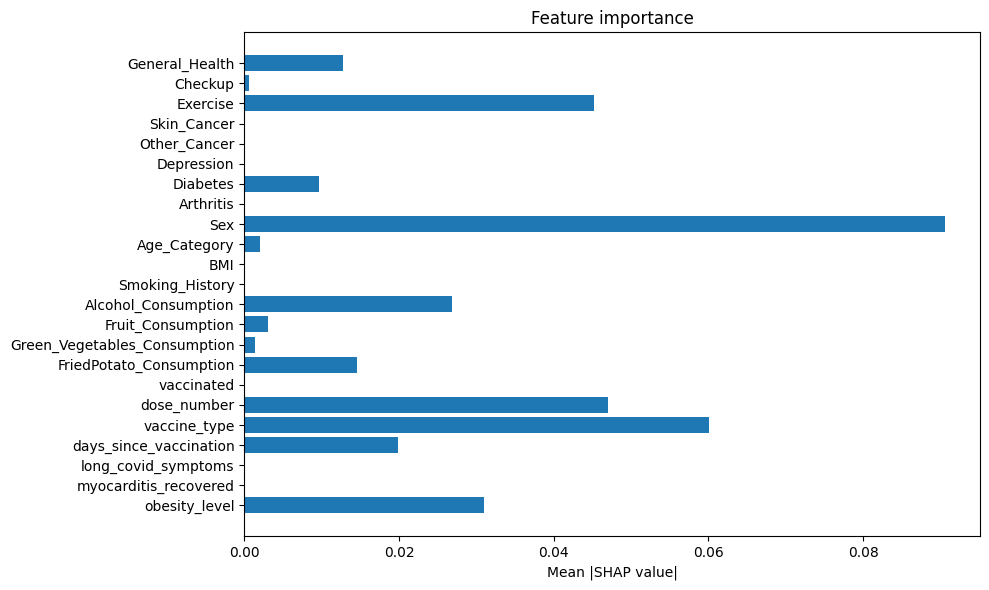

In [122]:

mean_shap = np.abs(shap_values_class1).mean(axis=0)
feature_names = X_test_df.columns.tolist()

# Plot manually
plt.figure(figsize=(10, 6))
plt.barh(feature_names, mean_shap)
plt.xlabel("Mean |SHAP value|")
plt.title("Feature importance")
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

# Custom SHAP Dot Plot

In [133]:
# Get mean absolute SHAP values to rank features
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[-10:][::-1]  # Top 10 features

# Extract corresponding SHAP values and feature values
top_shap_values = shap_values_class1[:, top_indices]
top_features = X_test_df.iloc[:, top_indices]
top_feature_names = X_test_df.columns[top_indices]


In [134]:
# Convert to long-form DataFrame for seaborn
shap_df = pd.DataFrame(top_shap_values, columns=top_feature_names)
feature_df = pd.DataFrame(top_features, columns=top_feature_names)

melted_data = pd.melt(
    shap_df.assign(ID=shap_df.index),
    id_vars="ID",
    var_name="Feature",
    value_name="SHAP"
)

melted_feat = pd.melt(
    feature_df.assign(ID=feature_df.index),
    id_vars="ID",
    var_name="Feature",
    value_name="FeatureValue"
)

# Merge SHAP values and feature values
merged_df = pd.merge(melted_data, melted_feat, on=["ID", "Feature"])


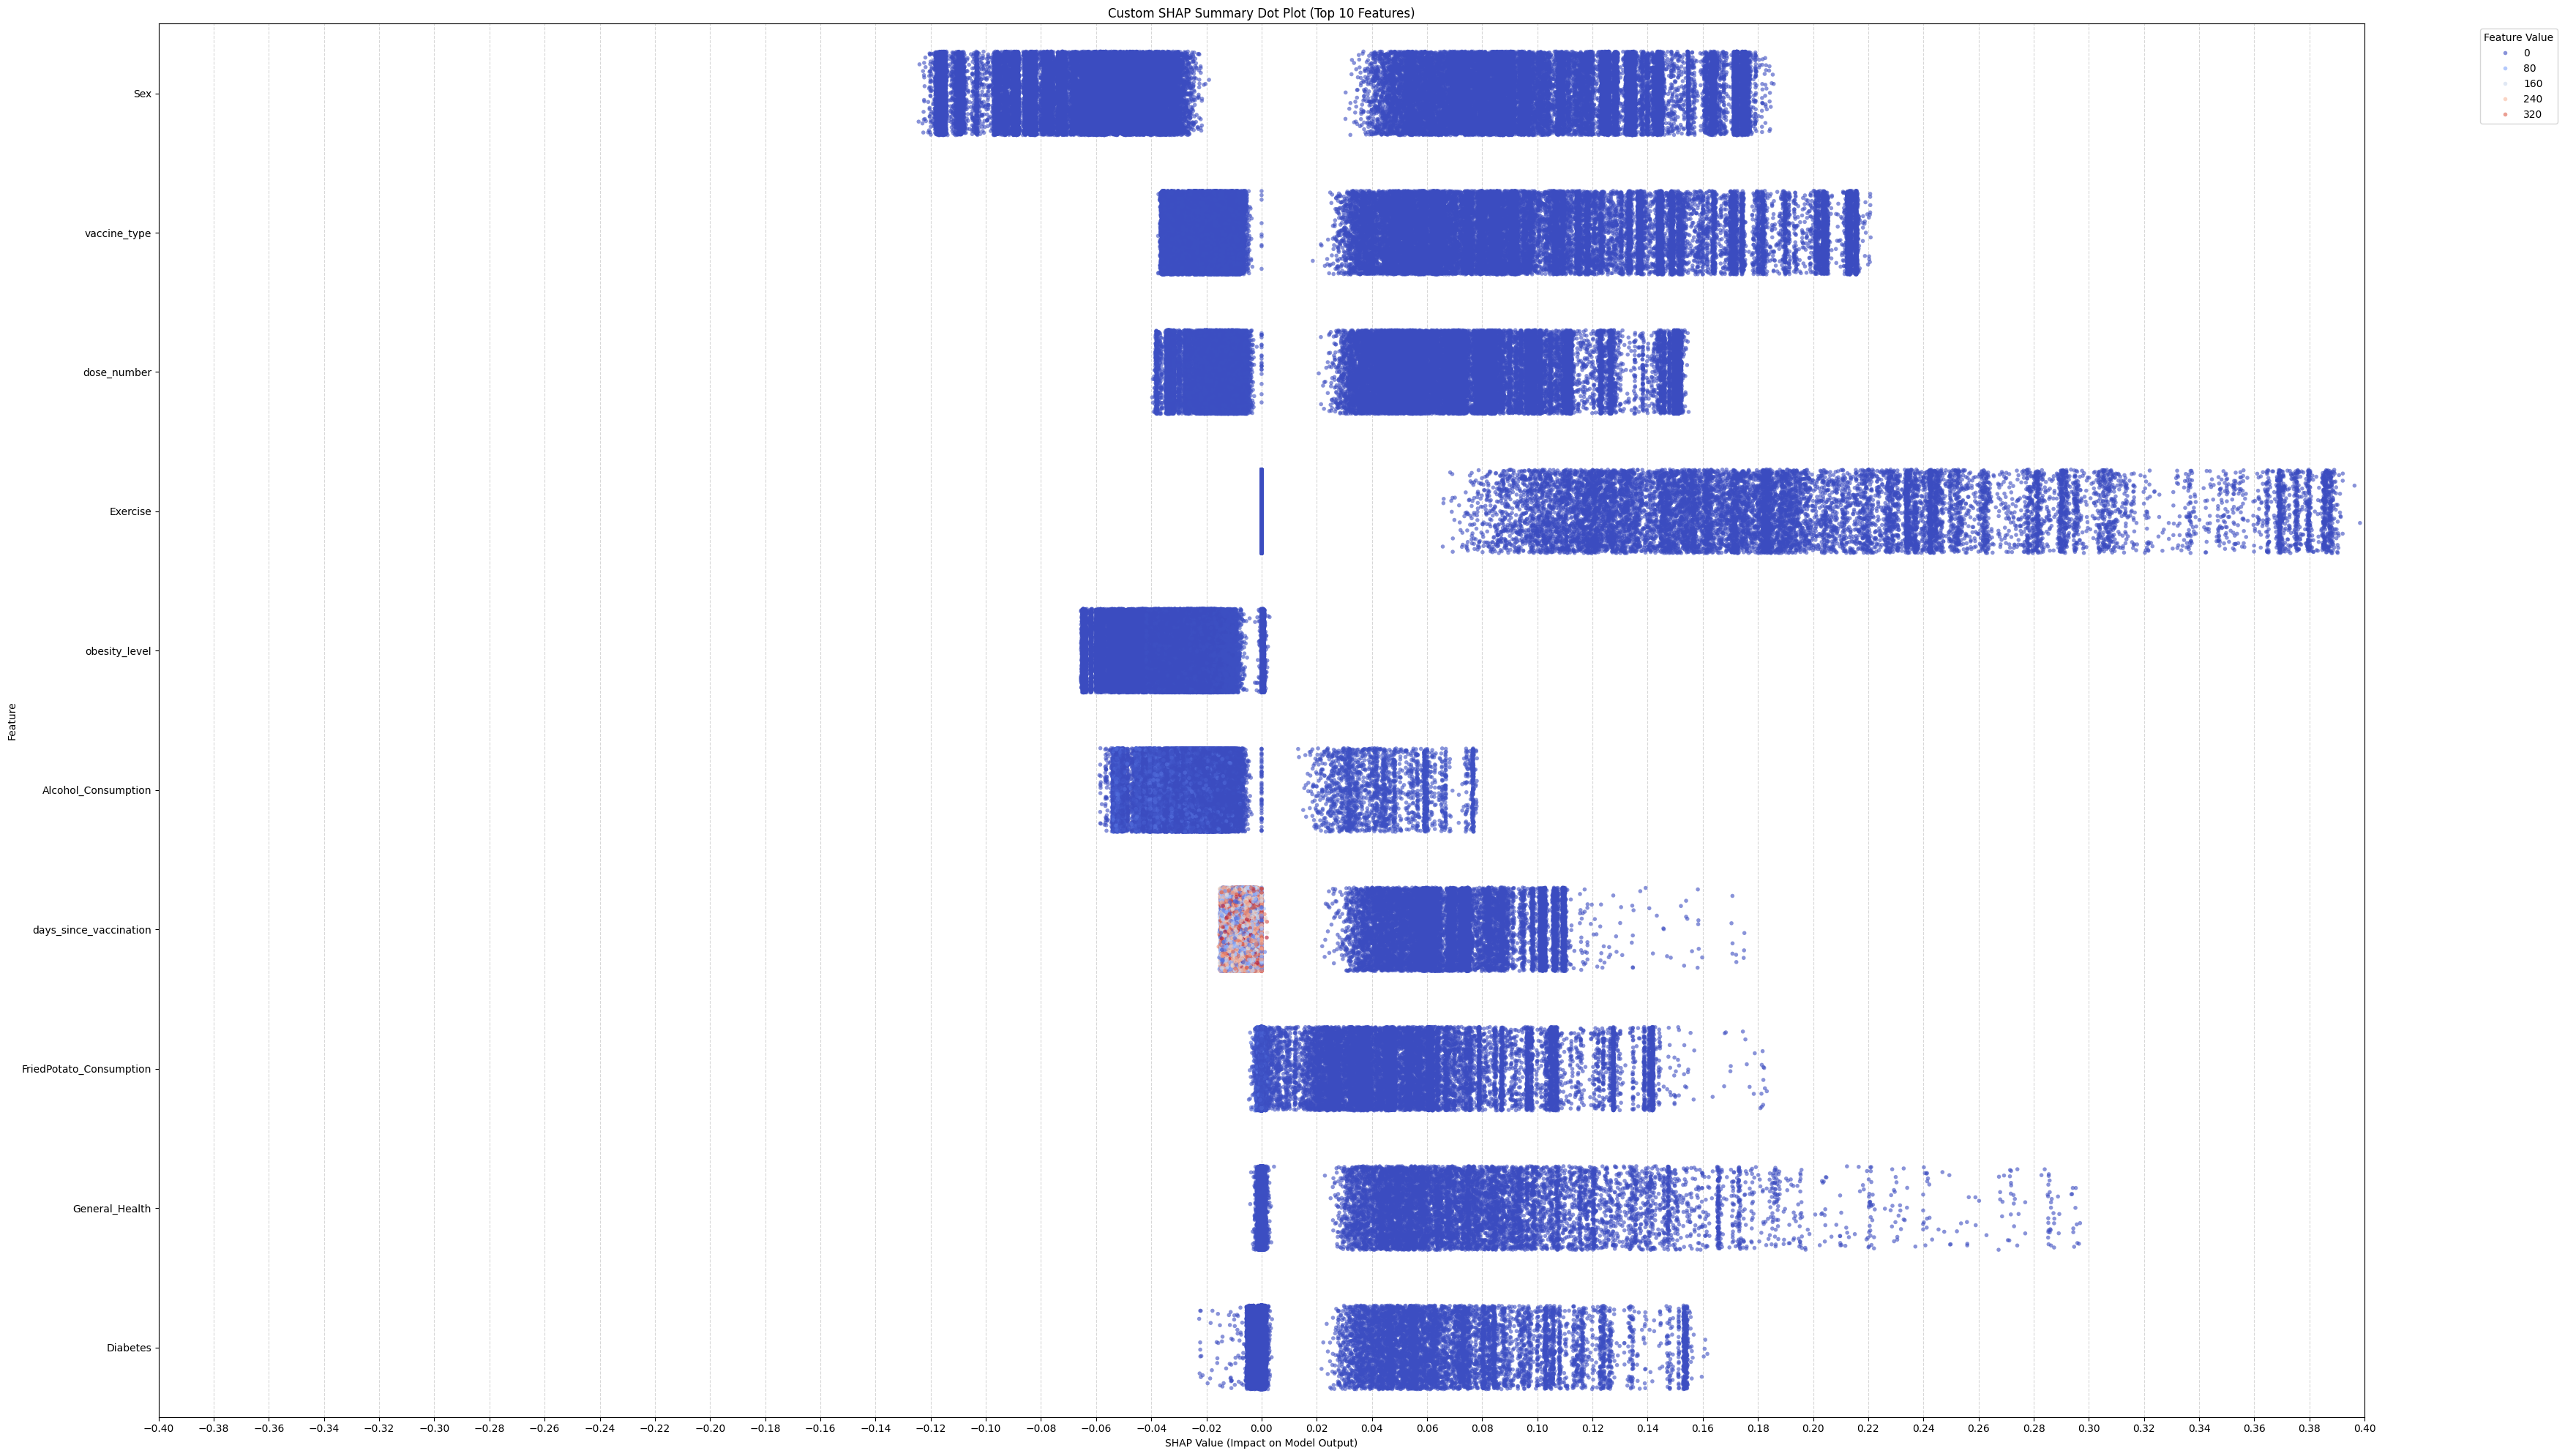

In [141]:
plt.figure(figsize=(35, 20))
sns.stripplot(
    data=merged_df,
    y="Feature",
    x="SHAP",
    hue="FeatureValue",
    palette="coolwarm",
    size=4,          # dot size
    alpha=0.6,       # transparency
    jitter=0.3,      # controls vertical spread (helps separate dots)
    linewidth=0
)

plt.title("Custom SHAP Summary Dot Plot (Top 10 Features)")
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.ylabel("Feature")
plt.legend(title="Feature Value", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.xlim(-0.4, 0.4)  # optional, adjust to your SHAP range
plt.xticks(np.arange(-0.4, 0.41, 0.02))  # fine-tuned control

plt.tight_layout()
plt.show()
